# Phase 4 AstroPi team Atlantes

## Introducción

En esta fase 4 del proyecto, dispondremos de los datos generados en la fase 3 por nuestro programa ejecutado en la Raspberry a bordo de la ISS. El objetivo de nuestro proyecto es hacer música con los datos obtenidos, es decir proceder a su [sonificación](https://en.wikipedia.org/wiki/Sonification). Una vez obtenido el sonido haremos una película [stopmotion](https://es.wikipedia.org/wiki/Animaci%C3%B3n_en_volumen) con las fotos obtenidas por la cámara de la Raspberry a la que superpondremos la sonificación de los datos de forma sincronizada.

El proyecto propuesto en fase 1 pretendía consultar una fuente de datos meteorológicos históricos para obtener las condiciones climáticas en tierra en el momento y los lugares por los que pasó la ISS durante la ejecución de nuestro programa. Buscaremos una fuente de datos de este tipo y analizaremos si nos ofrece datos adecuados para nuestro propósito.

Para analizar los datos utilizaremos representaciones en gráficas de las distintas columnas de datos obtenidos. Así identificaremos los que pueden resultar más adecuados para su sonificación. Aprenderemos por tanto a dibujar varias de estas columnas en la misma gráfica para poder compararlas.

Una vez decidida la información que vamos a sonificar, utilizaremos código Python para producir a partir de los datos un fichero de sonido como resultado de nuestro proyecto.

## Preparando el entorno

Para que este cuaderno se ejecute correctamente hay que instalar unos paquetes en el sandbox de Google Colab. También instalaremos los datos recopilados en la ISS y algunos ficheros necesarios.

In [1]:
!apt-get install -y fluidsynth fluid-soundfont-gm timidity ffmpeg
!pip install meteostat geopandas pretty-midi MIDIUtil matplotlib jupyter
!wget https://niubit.net/media/uploads/images/atlantes/atlantes_files_for_colab.zip -O atlantes_files_for_colab.zip
!unzip -o -q atlantes_files_for_colab.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following additional packages will be installed:
  freepats libaudio2 libfluidsynth1 libqt5x11extras5 qsynth timidity-daemon
Suggested packages:
  fluid-soundfont-gs nas jackd pmidi
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth freepats libaudio2 libfluidsynth1
  libqt5x11extras5 qsynth timidity timidity-daemon
0 upgraded, 9 newly installed, 0 to remove and 39 not upgraded.
Need to get 149 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubun

La siguiente celda de código termina de preparar el entorno y define algunas variables.

In [2]:
%pylab inline
import os

# Adjusting chart dimensions    
plt.rcParams["figure.figsize"] = (10, 8)                  # Size of charts in inches
plt.rcParams["figure.dpi"] = 90                           # Resolution of charts in DPIs

# Defining some environment variables for data sources
path = os.path.dirname(os.path.realpath("__file__"))
path_atlantes = path + "/atlantes"

RESULTS_FILE = "atlantes.csv"                             # ESA CSV file
RESULTS_FILE2 = "atlantes_stations.csv"                   # New CSV file with meteostat stations data
RESULTS_FILE3 = "atlantes_means.csv"                      # New CSV file with pictures data
RESULTS_FILE4 = "atlantes_stations_plus_hourly.csv"       # New CSV file with hourly meteostat data

Populating the interactive namespace from numpy and matplotlib


## Fuente de datos meteorológicos

La mejor fuente encontrada ha resultado ser [Meteostat](https://meteostat.net/en). Es libre, ofrece datos históricos y además tiene una [librería Python](https://dev.meteostat.net/python/) para obtener los datos desde código. Empezaremos analizando el sitio web de Meteostat consultando por ejemplo los datos [históricos que se pueden consultar sobre Zaragoza](https://meteostat.net/en/place/ES-SIWO).

Analizando el [código básico de ejemplo de la librería meteostat](https://dev.meteostat.net/python/#example), vemos que las coordenadas de latitud/longitud introducidas como parámetros en el código, se utilizan para localizar en primer lugar la estación meteorológica más cercana, de la que luego se obtendrán los datos históricos. Es decir, los datos no procederán casi nunca de la localización exacta de la ISS, sino de la estación más cercana. Esto tiene sentido, pero nos hace darnos cuenta de que tal vez tengamos un problema, ya que la mayor parte del tiempo la ISS vuela sobre el mar, donde es de esperar que existan pocas estaciones. Cuando lo hace sobre tierra cada 15 segundos que es el intervalo de las fotos y la toma de datos se recorren aproximadamente 100km, por lo que al menos en las zonas pobladas es de esperar que podremos alcanzar la precisión suficiente.

Será lo primero que vamos a analizar es decir, hasta qué punto las posiciones de sobrevuelo de la ISS están cubiertas por Meteostat con suficiente precisión. Vamos a recorrer el fichero CSV de datos de nuestro programa (`atlantes.csv`) para localizar la estación meteorológica de Meteostat más cercana a cada punto para ver con qué frecuencia cambia o se repite la estación. Luego representaremos estas estaciones sobre un mapa terrestre y compararemos los puntos con los de las posiciones de la ISS.

## Aprendiendo a trabajar con datos

Antes tenemos que aprender una serie de técnicas en Python para acceder y manejar los datos del fichero CSV.

El siguiente bloque de código utiliza la librería Python [`pandas`](https://pandas.pydata.org/pandas-docs/stable/index.html) para leer el fichero CSV. Lo carga sobre una estructura de datos propia de esta librería que facilita mucho la manipulación de matrices de datos del estilo de una hoja de cálculo. Vamos a empezar imprimiendo en pantalla la estructura de datos directamente para ver qué tenemos entre manos. Como contendrá muchos datos vamos a ver sólo las dos primeras filas, cosa que conseguimos con la función `head()`:

In [3]:
import os
import csv
import pandas

# Building file path
file = os.path.join(path_atlantes, RESULTS_FILE)

# Loading CSV file on memory
data = pandas.read_csv(file)
cut_data = data.head(2)                 # We get only the first two rows

print(cut_data)

                     datetime      picture_file  ...    gyro_y    gyro_z
0  2021-04-16 19:46:29.962262  atlantes_001.jpg  ...  0.103140 -0.002145
1  2021-04-16 19:46:44.962429  atlantes_002.jpg  ...  0.104362  0.001215

[2 rows x 21 columns]


Cuando queramos una única columna de datos será tan sencillo como indicar el nombre de la columna (el primer valor de la columna en el fichero CSV que actúa a modo de cabecera) separado de la estructura de datos con un punto: 

In [4]:
import os
import csv
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)

data = pandas.read_csv(file)
sub_data = data.latitude                # Data subset with 'latitude' column
cut_data = sub_data.head(2)             # We get only the first two rows

print(cut_data)

0    11.886359
1    11.236407
Name: latitude, dtype: float64


Cuando queramos un conjunto de columnas, es decir una especie de subconjunto de la hoja CSV, utilizaremos la propiedad [`loc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) de la siguiente forma:

In [5]:
import os
import csv
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)

data = pandas.read_csv(file)
# Data subset with 4 specific columns
sub_data = data.loc[:, ["datetime", "picture_file", "latitude", "longitude"]]
cut_data = sub_data.head(2)             # We get only the first two rows

print(cut_data)

                     datetime      picture_file   latitude  longitude
0  2021-04-16 19:46:29.962262  atlantes_001.jpg  11.886359 -45.170913
1  2021-04-16 19:46:44.962429  atlantes_002.jpg  11.236407 -44.682531


Por último vamos a ver cómo iterar la estructura de datos para procesar cada fila que devuelve. Para conseguirlo utilizaremos la función [`iterrows()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) que nos devuelve para cada fila un índice y un diccionario con los datos que contiene.

In [6]:
import os
import csv
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)

data = pandas.read_csv(file)
# Data subset with 4 specific columns
sub_data = data.loc[:, ["datetime", "picture_file", "latitude", "longitude"]]
cut_data = sub_data.head(2)             # We get only the first two rows

for index, row in cut_data.iterrows():
    print(index)
    print(row["datetime"])
    print(row["picture_file"])
    print()

0
2021-04-16 19:46:29.962262
atlantes_001.jpg

1
2021-04-16 19:46:44.962429
atlantes_002.jpg



## Localización de las estaciones meteorológicas

Ahora que ya sabemos leer los datos, vamos a empezar a procesarlos. Comenzaremos preprocesando algunos datos para poder representarlos gráficamente más adelante. Lo que vamos a hacer ahora es generar un nuevo fichero CSV con algunas columnas del fichero original que nos servirán de índice (para poder cruzar los datos entre varios ficheros) a las que añadiremos columnas nuevas con datos de las estaciones meteorológicas más próximas a la latitud/longitud en la que se encontraba la ISS en cada iteración.

El siguiente bloque de código coge el fichero `atlantes.csv` y para cada fila realiza lo siguiente:

1. Obtiene las columnas de la latitud/longitud.
2. Consulta la estación meteorológica más cercana a esa posición.
3. En un nuevo CSV registra los siguientes datos con la cabecera que se indica:
    * `datetime`: fecha/hora procedente del fichero original
    * `picture_file`: nombre de fichero de la foto procedente del fichero original
    * `latitude`: latitud procedente del fichero original
    * `longitude`: longitud procedente del fichero original
    * `station_id`: ID de la estación meteorológica en la base de datos de meteostat
    * `station`: nombre de la estación meteorológica
    * `country`: pais de la estación meteorológica
    * `st_lat`: latitud de la estación meteorológica
    * `st_lon`: longitud de la estación meteorológica

El resultado de todo esto será el nuevo fichero `atlantes_stations.csv` que generaremos en el mismo directorio donde estaba la fuente de datos `atlantes.csv`.

Esta vez vamos a trabajar con la fuente de datos (el fichero CSV original) completa, por lo que la ejecución puede tardar bastante tiempo en completarse (unos 5 minutos).

In [7]:
import os
import csv
import pandas
from meteostat import Stations

file_in = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV entrada
file_out = os.path.join(path_atlantes, RESULTS_FILE2)  # Ruta completa fichero CSV salida
# Objeto de la librería meteostat para consultar estaciones meteorológicas de la base de datos meteostat
stations = Stations()

file = open(file_out, 'w', newline='', encoding='utf-8')     # Abrimos fichero de salida en modo escritura (`w`)

# Leemos las columnas que nos interesan del fichero original
data = pandas.read_csv(file_in).loc[:, ["datetime", "picture_file", "latitude", "longitude"]]

# Escribimos cabecera de las columnas del fichero de salida
header = ("datetime", "picture_file", "latitude", "longitude", "station_id", "station", "country", "st_lat", "st_lon")
csv.writer(file).writerow(header)

# Iteramos los datos del fichero de entrada
for index, row in data.iterrows():
    # Buscamos la estación meteorológica más cercana al punto sobre el que se encontraba la ISS
    station = stations.nearby(row["latitude"], row["longitude"]).fetch(1)
    # Escribimos los datos en el fichero de salida
    csv.writer(file).writerow((row["datetime"], row["picture_file"], row["latitude"], row["longitude"], station.index[0], station["name"][0], station["country"][0], station["latitude"][0], station["longitude"][0]))

# Cerramos el fichero de salida
file.close()

# Avisamos de la finalización del proceso
print("Fichero '%s' generado." % (file_out))

Fichero '/content/atlantes/atlantes_stations.csv' generado.


Así pues ahora, tenemos en un mismo fichero los datos de la posición de la ISS en cada iteración de nuestro programa de captura de datos, junto a la posición de la estación meteorológica más próxima.

Aquí empieza lo interesante. Vamos a dibujar sobre un plano dichas posiciones (gracias a [este artículo](https://coderzcolumn.com/tutorials/data-science/plotting-static-maps-with-geopandas-working-with-geospatial-data) por la idea) para así comprobar si los datos que obtendremos de las estaciones tendrán la suficiente precisión.

El siguiente bloque de código dibuja y georreferencia sobre un plano terrestre las posiciones de la ISS en azul y las de las estaciones meteorológicas más próximas en rojo.

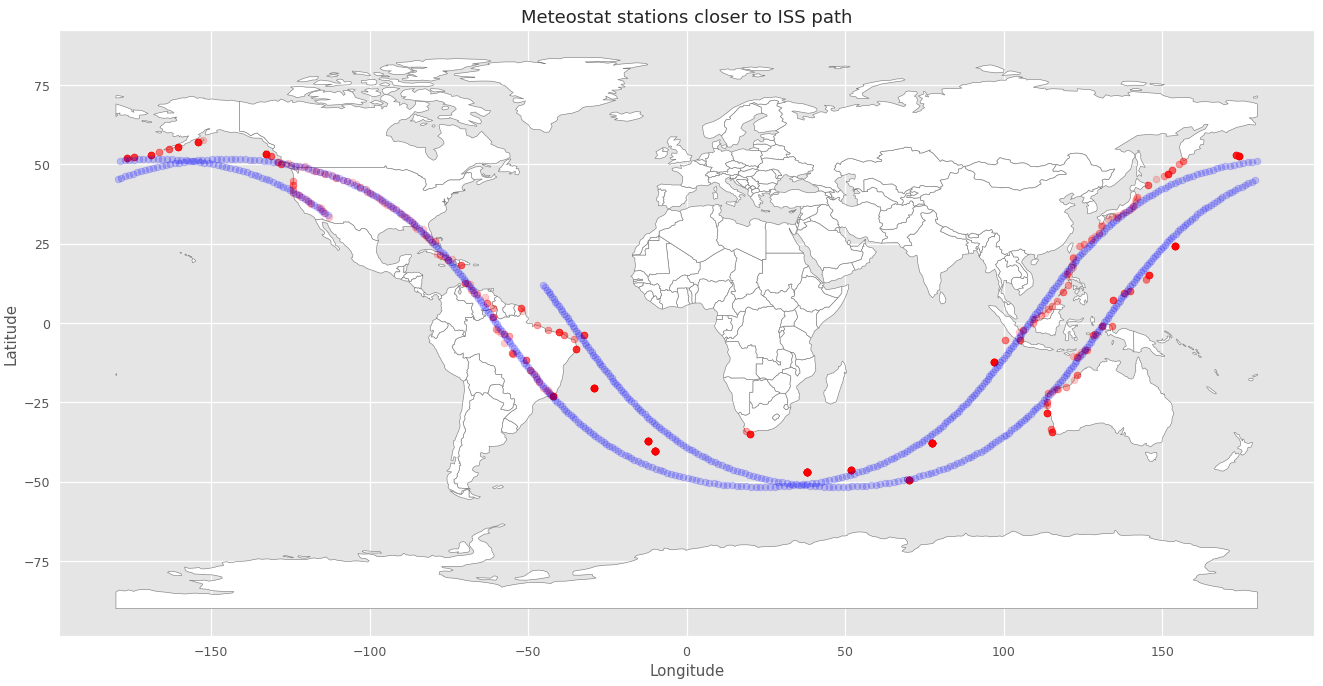

In [8]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE2)  # Ruta completa fichero CSV entrada

data = pandas.read_csv(file)                  # Leemos el fichero completo

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    # Dibujamos en rojo los puntos de las estaciones meteorológicas más próximas a la ISS
    plt.scatter(data.st_lon, data.st_lat, zorder=1, alpha= 0.2, c='red', s=30)
    # Dibujamos en azul los puntos donde se encontraba la ISS en cada iteración
    plt.scatter(data.longitude, data.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Meteostat stations closer to ISS path");

Podemos ver cómo cuando la ISS sobrevuela zonas de tierra (sobre todo en América), hay numerosas estaciones meteorológicas de manera que las dos curvas casi se ajustan perfectamente. Sin embargo en la mayoría de las zonas, sobretodo cuando sobrevuela el mar, las estaciones dan saltos muy grandes. Los puntos se han representado con cierto nivel de transparencia, de manera que el nivel de opacidad del punto indica el número de veces que se repite una misma estación. Por eso las estaciones meteorológicas representadas sobre el mar tienen un rojo más intenso.

Podemos recortar el gráfico para fijarnos con más detalle en algunas zonas, como el sobrevuelo de América, ajustando los extremos de los ejes X e Y.

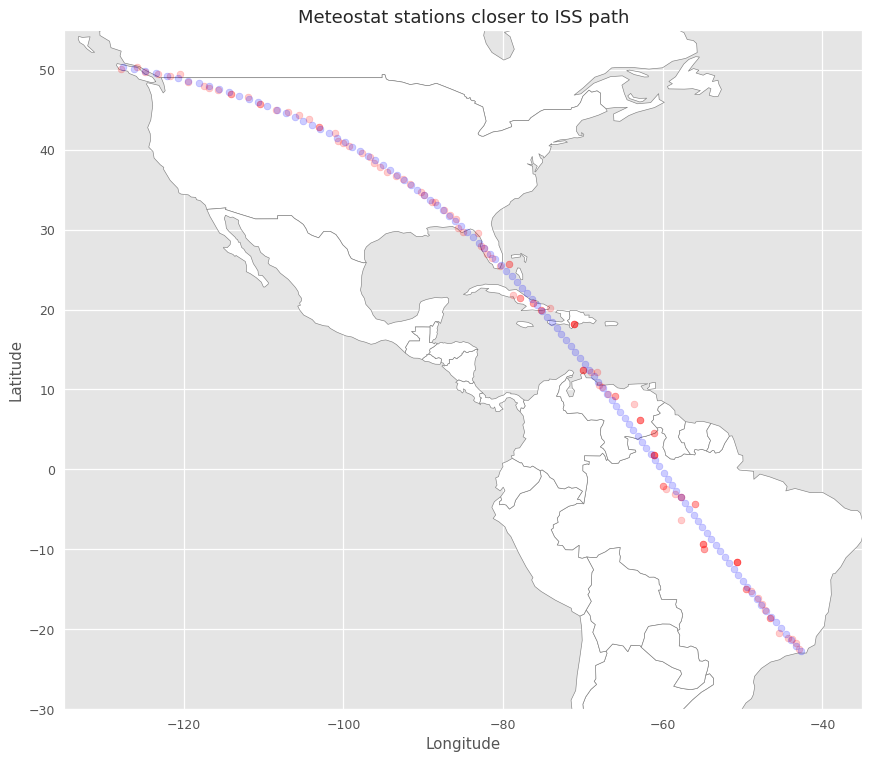

In [9]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE2)  # Ruta completa fichero CSV entrada

data = pandas.read_csv(file, nrows=419).tail(113)          # Leemos los datos del sobrevuelo americano (307 -> 419)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    # Dibujamos en rojo los puntos de las estaciones meteorológicas más próximas a la ISS
    plt.scatter(data.st_lon, data.st_lat, zorder=1, alpha= 0.2, c='red', s=30)
    # Dibujamos en azul los puntos donde se encontraba la ISS en cada iteración
    plt.scatter(data.longitude, data.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Meteostat stations closer to ISS path");
    plt.gca().set_xlim(-135, -35)                          # Ajustamos los límites del eje X
    plt.gca().set_ylim(-30, 55)                            # Ajustamos los límites del eje Y

Resulta curioso ver cómo en el norte de América prácticamente hay una estación meteorológica justo debajo de cada posición de la ISS. Esta situación empeora al adentrarnos en el sur de América.

También ayuda a entender el problema la representación de los puntos de las estaciones únicamente.

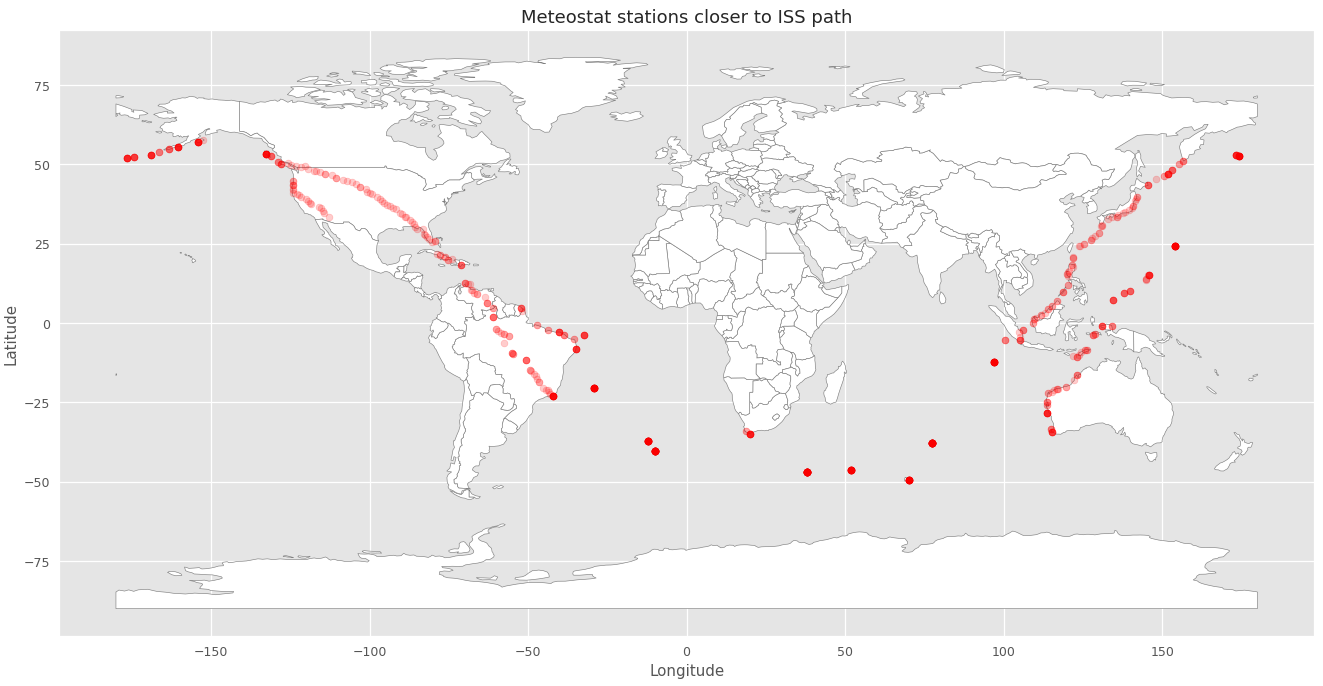

In [10]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE2)  # Ruta completa fichero CSV entrada

data = pandas.read_csv(file)                  # Leemos el fichero completo

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    # Dibujamos en rojo los puntos de las estaciones meteorológicas más próximas a la ISS
    plt.scatter(data.st_lon, data.st_lat, zorder=1, alpha= 0.2, c='red', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Meteostat stations closer to ISS path");

Lo siguiente que haremos es localizar algunos puntos interesantes de la serie de datos. Visualizando las fotos y apoyándonos en la representación de los puntos que hemos hecho sobre el plano terrestre, podemos destacar los siguientes puntos (los indicaremos con el nombre del archivo de la foto):

|Foto|Hora|Latitud|Longitud|Zona|GMaps|Evento|
|:---|:---|:------|:-------|:---|:----|:------|
|atlantes_038.jpg|19:55:44|-15.930611|-24.8557447|Atlántico Sur|[Ver](https://goo.gl/maps/CHLZuX2VouyLZW1F9)|Puesta de sol en Tierra|
|atlantes_059.jpg|20:00:59|-30.835167|-11.039583|Atlántico Sur|[Ver](https://goo.gl/maps/W1tcUhtfSUg75Pv27)|Puesta de sol en ISS|
|atlantes_172.jpg|20:29:14|-22.955139|113.971111|Lyndon Australia Occidental 6701, Australia|[Ver](https://goo.gl/maps/k7pcNEWZQ8wMmfbG7)|Rozamos el noroeste de Australia (de noche)|
|atlantes_186.jpg|20:32:44|-12.696889|122.401889|Oceano Índico|[Ver](https://goo.gl/maps/NE26MTBpryoxowxN8)|Salida de sol en ISS|
|atlantes_208.jpg|20:38:14|3.935500|134.405194|Pacífico Norte|[Ver](https://goo.gl/maps/Z3auiDeyTtsQGLXY9)|Salida de sol en Tierra|
|atlantes_307.jpg|21:03:00|50.315444|-127.637972|Mount Waddington B, Columbia Británica, Canadá|[Ver](https://goo.gl/maps/TT29TYdrg9sQjVRp6)|Entramos en Norteamérica por Vancouver|
|atlantes_354.jpg|21:14:45|25.587417|-80.278167|Bahía Vizcaína, Florida, EE. UU.|[Ver](https://goo.gl/maps/vTiZMuaKD4oBCAVZA)|Salimos de Norteamérica por Florida|
|atlantes_361.jpg|21:16:30|20.581278|-75.737639|Parque Nacional la Mensura, Cuba|[Ver](https://goo.gl/maps/TYtAw2YighVEzSyKA)|Atravesamos Cuba|
|atlantes_375.jpg|21:20:00|10.210778|-67.528250|Francisco Linares Alcántara, Aragua, Venezuela|[Ver](https://goo.gl/maps/Jafv6Diq6jrubAxL8)|Entramos en Sudamérica por Venezuela|
|atlantes_409.jpg|21:28:30|-15.460444|-48.835306|Vila Propício - Goiás, Brasil|[Ver](https://goo.gl/maps/XmUCCiBxFYbwRfz56)|Puesta de sol en Tierra|
|atlantes_419.jpg|21:31:00|-22.755972|-42.721722|Pitangas, Tanguá - Estado de Río de Janeiro, Brasil|[Ver](https://goo.gl/maps/XCbTjLmB2pYCdT8z8)|Salimos de Sudamérica por Brasil (de noche)|
|atlantes_431.jpg|21:34:00|-31.078889|-34.374528|Atlántico Sur|[Ver](https://goo.gl/maps/TaNCgeFUYze6ocJS9)|Puesta de sol en ISS|
|atlantes_558.jpg|22:05:45|-12.424111|98.999056|Océano Índico|[Ver](https://goo.gl/maps/PbLcyFiCTmpfuxFv5)|Salida de sol en ISS|
|atlantes_568.jpg|22:08:15|-4.892667|104.524250|Bonglai, Banjit, Way Kanan, Lampung, Indonesia|[Ver](https://goo.gl/maps/7FMihUnspsf9Hpgo6)|Atravesamos Indonesia (de noche)|
|atlantes_579.jpg|22:11:00|3.454056|110.452167|Mar de la China Meridional|[Ver](https://goo.gl/maps/39qwLnvBm84TEzLx8)|Salida de sol en Tierra|
|atlantes_598.jpg|22:15:45|17.696722|121.141833|Katablangan, Conner, Apayao, Filipinas|[Ver](https://goo.gl/maps/uD1Bp2Wso1iLWcXN9)|Atravesamos Filipinas|
|atlantes_624.jpg|22:22:15|35.641417|139.452500|Renkōji, Tama, Tokyo, Japón|[Ver](https://goo.gl/maps/rq9baVAamvxd9vG28)|Atravesamos Japón (muy nublado)|
|atlantes_701.jpg|22:41:30|41.288306|-124.100111|Redwoods National Park ASBS State Water Quality Protection Area, California, EE. UU.|[Ver](https://goo.gl/maps/gwPPCWRfwoWGFyZa7)|Entramos en Norteamérica por California|

Vamos a volver a representar las posiciones de la ISS sobre el plano terrestre pero esta vez señalando con distintos colores el nivel de insolación en el momento de realizar la foto. Dibujaremos los puntos correspondientes a la fase diurna en naranja, los anocheceres y amaneceres en rojo y la fase nocturna en azul.

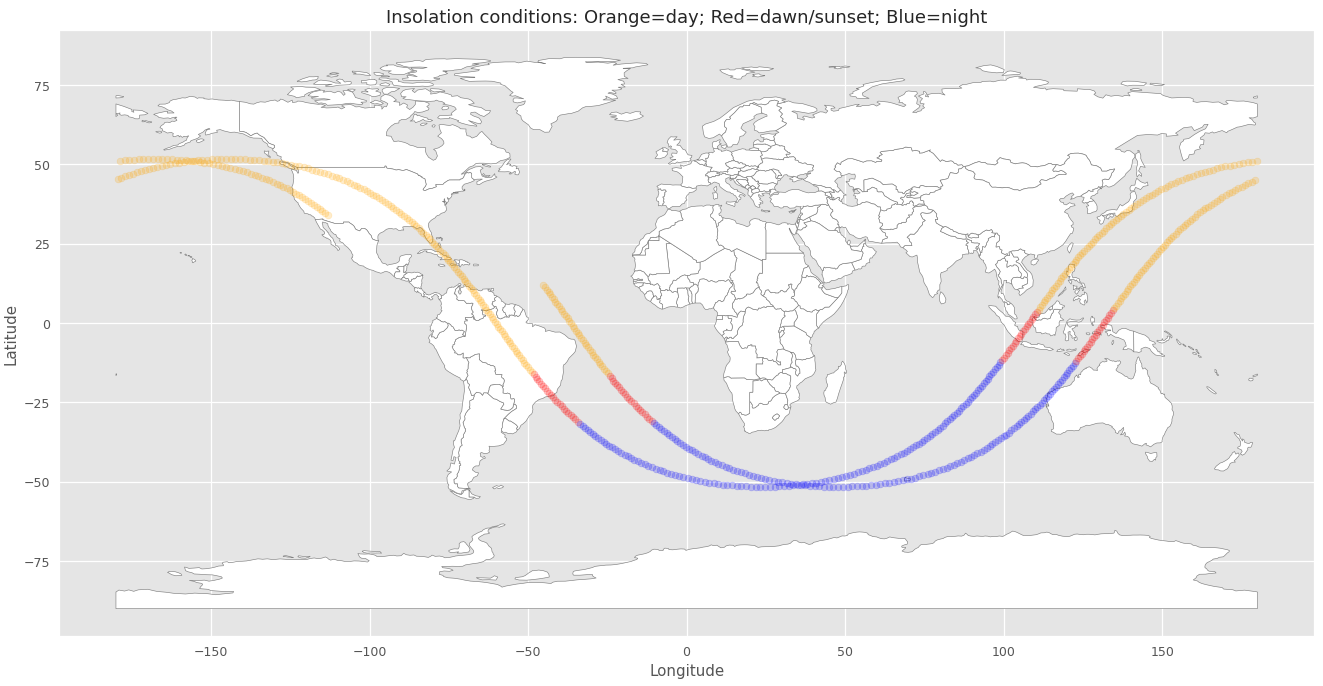

In [11]:
import os
import pandas
import matplotlib.pyplot as plt
import geopandas

file = os.path.join(path_atlantes, RESULTS_FILE2)  # Ruta completa fichero CSV entrada

#data = pandas.read_csv(file)                  # Leemos el fichero completo
dataD1 = pandas.read_csv(file, nrows=38).tail(38)                  # Día 1
dataA1 = pandas.read_csv(file, nrows=59).tail(21)                  # Anochecer 1
dataN1 = pandas.read_csv(file, nrows=186).tail(127)                # Noche 1
dataM1 = pandas.read_csv(file, nrows=208).tail(22)                 # Amanecer 1
dataD2 = pandas.read_csv(file, nrows=409).tail(201)                # Día 2
dataA2 = pandas.read_csv(file, nrows=431).tail(22)                 # Anochecer 2
dataN2 = pandas.read_csv(file, nrows=558).tail(127)                # Noche 2
dataM2 = pandas.read_csv(file, nrows=579).tail(21)                 # Amanecer 2
dataD3 = pandas.read_csv(file, nrows=713).tail(134)                # Día 3

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10), color="white", edgecolor="grey")
    plt.scatter(dataD1.longitude, dataD1.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.scatter(dataA1.longitude, dataA1.latitude, zorder=1, alpha= 0.2, c='red', s=30)
    plt.scatter(dataN1.longitude, dataN1.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.scatter(dataM1.longitude, dataM1.latitude, zorder=1, alpha= 0.2, c='red', s=30)
    plt.scatter(dataD2.longitude, dataD2.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.scatter(dataA2.longitude, dataA2.latitude, zorder=1, alpha= 0.2, c='red', s=30)
    plt.scatter(dataN2.longitude, dataN2.latitude, zorder=1, alpha= 0.2, c='blue', s=30)
    plt.scatter(dataM2.longitude, dataM2.latitude, zorder=1, alpha= 0.2, c='red', s=30)
    plt.scatter(dataD3.longitude, dataD3.latitude, zorder=1, alpha= 0.2, c='orange', s=30)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Insolation conditions: Orange=day; Red=dawn/sunset; Blue=night");

Con todo lo visto hasta ahora, se confirma que la mejor serie de datos es la que habíamos señalado antes y que corresponde al sobrevuelo sobre el continente americano, es decir entre las fotos `atlantes_307.jpg` y `atlantes_419.jpg`.

## Tratamiento de datos sobre las fotografías

Además de obtener datos de la mayoría de los sensores de SenseHAT, nuestro programa tomó una foto en cada iteración del bucle (cada 15 segundos). Estas fotos pueden considerarse también el resultado de la medición de un sensor (la cámara) y podemos extraer datos de las mismas. Un dato muy sencillo de obtener y de entender es el del promedio de todos los valores que tienen todos los píxeles de cada foto. Como sabemos, cada píxel tiene un valor entero de 0 a 255 para cada uno de los 3 canales de colores básicos (R: Rojo, G: Verde, B: Azul). También podemos promediar estos tres valores para cada píxel para obtener una especie de valor de luminosidad (es lo que se suele hacer para convertir las imágenes a blanco y negro). Así pues, en total vamos a obtener 4 valores promedio para cada foto:

* Promedio de luminosidad de todos los píxeles de cada foto.
* Promedio del valor R de todos los píxeles de cada foto.
* Promedio del valor G de todos los píxeles de cada foto.
* Promedio del valor B de todos los píxeles de cada foto.

Para no tener que estar calculando cada vez estos promedios, dado que es un proceso pesado (cada foto contiene millones de píxeles), vamos a hacer un programa para preprocesar estos datos y registrarlos en un nuevo fichero CSV de forma parecida a como hicimos con las estaciones meteorológicas más próximas.

El siguiente programa lee el fichero CSV que nos entregó la ESA con los datos originales registrados por la Raspberry y genera un nuevo fichero CSV con los cálculos realizados sobre las fotos de los cuatro promedios que hemos enumerado antes. El fichero original es `atlantes.csv` y el nuevo `atlantes_means.csv`.

In [12]:
import os
import csv
import pandas
from PIL import Image, ImageStat

file_in = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV entrada
file_out = os.path.join(path_atlantes, RESULTS_FILE3)  # Ruta completa fichero CSV salida

file = open(file_out, 'w', newline='', encoding='utf-8')     # Abrimos fichero de salida en modo escritura (`w`)

# Leemos las columnas que nos interesan del fichero original
data = pandas.read_csv(file_in).loc[:, ['datetime', 'picture_file']]

# Escribimos cabecera de las columnas del fichero de salida
header = ("datetime", "picture_file", "mean_global", "mean_r", "mean_g", "mean_b")
csv.writer(file).writerow(header)

# Iteramos los datos del fichero de entrada
for index, row in data.iterrows():
    # Cargamos en memoria la foto
    im = Image.open(os.path.join(path_atlantes, row[1]))
    # Obtenemos sus estadísticas, entre las que se incluyen los valores medios de los canales R, G y B
    stat = ImageStat.Stat(im)
    # Calculamos la media global
    mean = round(sum(stat.mean)/len(stat.mean), 2)
    # Escribimos los datos en el fichero de salida
    csv.writer(file).writerow((row[0], row[1], mean, round(stat.mean[0], 2), round(stat.mean[1], 2), round(stat.mean[2], 2)))

# Cerramos el fichero de salida
file.close()

# Avisamos de la finalización del proceso
print("Fichero '%s' generado." % (file_out))

Fichero '/content/atlantes/atlantes_means.csv' generado.


## Generación de gráficas

El fichero CSV generado en la fase 3 por nuestro programa ejecutado a bordo de la ISS contiene las siguientes columnas (y unidades):

* datetime (AAAA-MM-DD HH:MM:SS.mmm)
* picture_file (atlantes_NNN.jpg)
* latitude (º)
* longitude (º)
* temp_cpu (ºC)
* temp_h (ºC)
* temp_p (ºC)
* humidity (%)
* pressure (mbar)
* pitch (rad)
* roll (rad)
* yaw (rad)
* mag_x (μT)
* mag_y (μT)
* mag_z (μT)
* accel_x (g)
* accel_y (g)
* accel_z (g)
* gyro_x (rad/s)
* gyro_y (rad/s)
* gyro_z (rad/s)

A estas columnas podemos añadir los promedios de los píxeles de las fotos que hemos calculado antes, es decir:

* Promedio global (0-255)
* Promedio R (0-255)
* Promedio G (0-255)
* Promedio B (0-255)

Con todos estos datos vamos a dibujar gráficas para visualmente decidir cuales de ellos podrán resultar más adecuados para ser sonificados. Durante las comparaciones pueden darse dos situaciones:

1. Comparar datos con la misma unidad, como por ejemplo `temp_cpu`, `temp_h` y `temp_p`
2. Comparar datos con distintas unidades, como por ejemplo `temp_cpu` y `mag_x`

En el primer caso dibujaremos las clásicas gráficas con dos ejes de coordenadas, X y Y. En este caso podremos representar tantas columnas de datos como deseemos.

En el segundo caso haremos gráficos con dos ejes verticales, uno a cada lado de la gráfica. En este último caso sólo podremos representar dos columnas de datos. Vamos a ver cómo hacer estos dos tipos de gráficas.

### Gráficas tipo 1: Datos con misma unidad

Por ejemplo vamos a dibujar en una misma gráfica los cuatro promedios calculados sobre las fotos al principio de este cuaderno. Los datos los tomaremos por tanto del fichero CSV `atlantes_means.csv`. La columna `datetime` hay que convertirla a objetos Python datetime para que la librería de gráficos interprete correctamente las fechas. Esto se hace indicando la posición de la columna en el parámetro `parse_dates` de la función `read_csv()`.

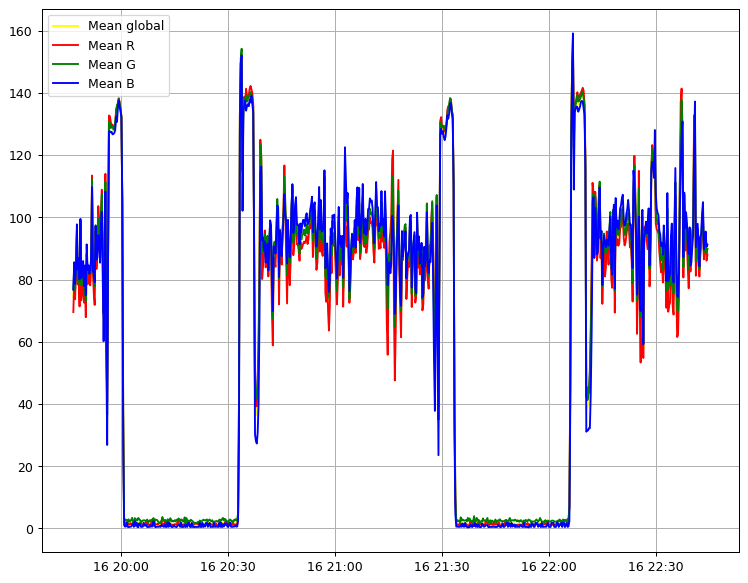

In [13]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE3)    # Ruta completa fichero CSV

# Leemos todo el fichero
data = pandas.read_csv(file, parse_dates=[0])

# Columnas en fichero: "datetime", "picture_file", "mean_global", "mean_r", "mean_g", "mean_b"
data_x = data.datetime                        # Datos de la columna 'datetime'
data_y1 = data.mean_global                    # Datos de la columna 'mean_global'
data_y2 = data.mean_r                         # Datos de la columna 'mean_r'
data_y3 = data.mean_g                         # Datos de la columna 'mean_g'
data_y4 = data.mean_b                         # Datos de la columna 'mean_b'

fig, ax = plt.subplots()                                      # Preparamos los objetos para dibujar con matplotlib
ax.plot(data_x, data_y1, label="Mean global", color="yellow") # Representamos los datos de 'mean_global' frente a 'datetime'
ax.plot(data_x, data_y2, label="Mean R", color="red")         # Representamos los datos de 'mean_r' frente a 'datetime'
ax.plot(data_x, data_y3, label="Mean G", color="green")       # Representamos los datos de 'mean_g' frente a 'datetime'
ax.plot(data_x, data_y4, label="Mean B", color="blue")        # Representamos los datos de 'mean_b' frente a 'datetime'

plt.legend()                                  # Incluimos una leyenda en la gráfica
plt.grid()                                    # Incluimos una rejilla en la gráfica
plt.show()                                    # Mostramos la gráfica

A la vista de esta gráfica ya vemos que no hay demasiada diferencia entre los distintos canales de color de las fotos. A pesar de ello intentaremos "interpretar" cada canal con un instrumento distinto, ya que seguramente resultará un sonido armónico y con esas pequeñas disonancias o imperfecciones que se producen en una interpretación hecha por humanos.

### Gráficas tipo 2: Datos con distintas unidades

Para ilustrar este caso vamos a representar por ejemplo las columnas de datos `temp_p` (eje izquierdo) y `pressure` (eje derecho) frente al tiempo (gracias a [este artículo](https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/) por el ejemplo). En este caso utilizaremos el fichero CSV generado por la Raspberry directamente, es decir el `atlantes.csv`. En el código indicamos todas las cabeceras de las columnas que podríamos utilizar.

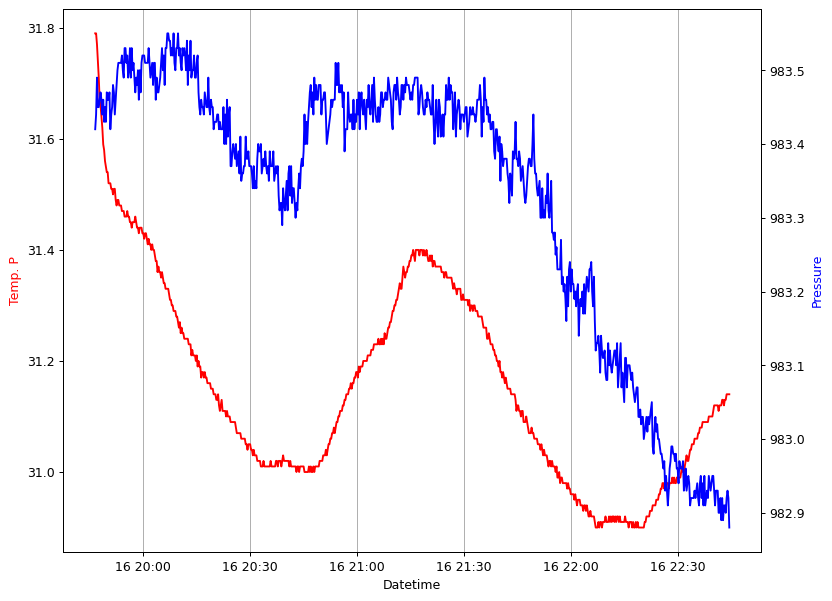

In [14]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV

# Leemos todo el fichero
data = pandas.read_csv(file, parse_dates=[0])

# Columnas en fichero:
#     "datetime", "picture_file", "latitude", "longitude", "temp_cpu", "temp_h", "temp_p",
#     "humidity", "pressure", "pitch", "roll", "yaw", "mag_x", "mag_y", "mag_z",
#     "accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"

data_x = data.datetime                        # Datos de la columna 'datetime'
data_y1 = data.temp_p                         # Datos de la columna 'temp_p'
data_y2 = data.pressure                       # Datos de la columna 'pressure'

fig, ax = plt.subplots()                      # Preparamos los objetos para dibujar con matplotlib
ax.set_xlabel('Datetime')                     # Ponemos leyenda al eje X

ax.plot(data_x, data_y1, color="red")         # Representamos los datos de 'temp_p' frente a 'datetime' en rojo
ax.set_ylabel('Temp. P', color="red")         # Ponemos leyenda al eje Y

ax2 = ax.twinx()                              # Generamos un nuevo eje vertical en la gráfica
ax2.plot(data_x, data_y2, color="blue")       # Representamos los datos de 'pressure' frente a 'datetime' en azul
ax2.set_ylabel("Pressure", color="blue")      # Ponemos leyenda al segundo eje Y

ax.grid(axis='x')                             # Incluimos una rejilla del eje X en la gráfica
plt.show()                                    # Mostramos la gráfica

Si necesitamos comparar más de dos series distintas de datos, aún tenemos una opción, que es situar las series una encima de otra en distintos gráficos con el eje horizontal coincidente. Por ejemplo:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d8bad3f50>,
      dtype=object)

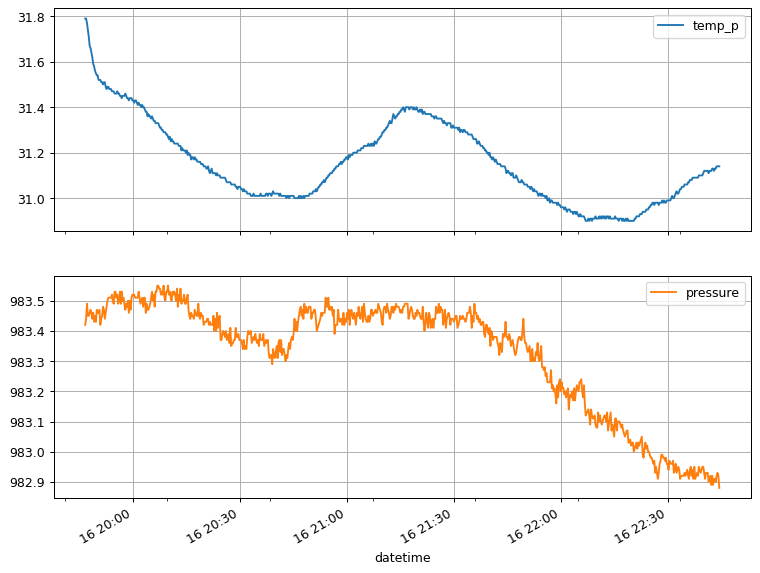

In [15]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV

# Leemos todo el fichero e indicamos la columna que actuará como índice común para todos los datos
data = pandas.read_csv(file, parse_dates=[0], index_col='datetime')

data[['temp_p', 'pressure']].plot(subplots=True, grid=True)

Aunque no estamos analizando los datos todavía, a la vista de la gráfica anterior no podemos dejar de destacar que se aprecia una evidente correlación entre la temperatura y presión del interior de la estación con el nivel de insolación, ya que los dos mínimos de ambas curvas, se corresponden bastante aproximadamente con los finales de los momentos en que la Tierra eclipsó al Sol en las casi dos órbitas completas de las que tenemos datos.

Con estas técnicas de representación podremos hacer un análisis de los datos de cara a identificar las mejores series de datos para proceder a su sonificación.

A continuación nos ocuparemos de las técnicas de sonificación propiamente dichas.

## Empezando a sonificar

Para sonificar series de datos, la mejor herramienta encontrada es la librería [sonify](https://github.com/erinspace/sonify). Aunque no vamos a utilizar la versión original sino una [modificada en Niubit](https://github.com/niubit/sonify) que permite más control sobre el escalado de los datos y guardar los ficheros MIDI generados. También modificamos el tempo para utilizar 60 beats por segundo que facilita el control de tiempos.

Una demostración de la librería en acción es el cuaderno [Graphs_and_Sounds](https://github.com/erinspace/sonify/blob/master/examples/Graphs_and_Sounds.ipynb) que se encuentra dentro del directorio `examples` tanto del [repositorio original](https://github.com/erinspace/sonify) como de [nuestro fork](https://github.com/niubit/sonify). Nosotros vamos a hacer lo mismo que se ve en ese cuaderno pero utilizando nuestros datos como fuente.

La librería `sonify` no se encuentra en [Pypi](https://pypi.org/) por lo que no puede instalarse con el comando `pip`. Hay que colocar su código fuente junto al cuaderno Jupyter o script Python que la utilizará. Si se ha ejecutado la primera celda de código de este cuaderno, ya tendremos la librería `sonify` instalada.

La sonificación la haremos con la función `create_midi_from_data()` a la que hay que pasar como argumentos una lista de tuplas (x, y) en donde `x` es el tiempo en segundos e `y` el código MIDI de la nota a producir. En la siguiente tabla podemos ver la correspondencia entre los códigos MIDI y las notas reales:

![MIDI table](https://niubit.net/media/uploads/images/atlantes/midinote2.jpeg)

Como vemos las notas pueden tener un valor entero de 0 a 127. Habrá pues que asegurarse de que la serie de datos que pasamos a la función `create_midi_from_data()` contiene números entre 0 y 127 en la segunda posición de cada tupla, es decir lo que hemos llamado `y` antes. Para facilitar esta tarea existe en la librería `sonify` la función `scale_list_to_range(list_to_scale, new_min, new_max)` a la que le pasamos la lista de datos y los extremos mínimo y máximo en donde queremos que se "reescale" nuestra lista. Es decir, se asignará el mínimo de la lista `list_to_scale` a `new_min` y el máximo a `new_max`; el resto de valores intermedios de la lista se repartirán de forma proporcional entre los dos extremos. Vamos a verlo con un ejemplo:

In [16]:
import sonify

my_list = [4, 6, 7, 8]

rescaled_list_14_18 = sonify.scale_list_to_range(my_list, 14, 18)
rescaled_list_0_100 = sonify.scale_list_to_range(my_list, 0, 100)

print(rescaled_list_14_18)
print(rescaled_list_0_100)

[14.0, 16.0, 17.0, 18.0]
[0.0, 50.0, 75.0, 100.0]


Existe otra función parecida en nuestro fork de la librería `sonify` que nos permite un mayor control en el escalado de los datos. Se trata de la función `scale_list_to_range2(list_to_scale, new_min, new_max, old_min, old_max)`. Funciona igual que la comentada antes, pero en lugar de utilizar como base del escalado los valores extremos de la lista, nos permite indicarlos manualmente. Lo vemos con un ejemplo:

In [17]:
import sonify

my_list = [4, 6, 7, 8]

rescaled_list_14_18 = sonify.scale_list_to_range2(my_list, 14, 18, 0, 10)
rescaled_list_0_100 = sonify.scale_list_to_range2(my_list, 0, 100, 0, 10)

print(rescaled_list_14_18)
print(rescaled_list_0_100)

[15.6, 16.4, 16.8, 17.2]
[40.0, 60.0, 70.0, 80.0]


### Sonificando una lista de un canal

Antes de sonificar los datos reales vamos a hacer una prueba sencilla para conocer el uso de la librería `sonify` sonificando la lista anterior. El valor `x` de las tuplas que como sabemos indica el tiempo en segundos lo incrementaremos medio segundo en cada tupla.

In [18]:
import sonify
import IPython

my_list = [4, 6, 7, 8]
snd_f = "my_list"

# Normalizamos los datos entre 20 y 100
normalized_list = sonify.scale_list_to_range2(my_list, new_min=20, new_max=100, old_min=0, old_max=10)

final_data = []
x = 0
for i in range(0, len(normalized_list)):
    final_data.append((x, normalized_list[i]))
    x += 0.5

sonify.create_midi_from_data(final_data, file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

fluidsynth: warning: Found samples with invalid loops, audible glitches possible.
Rendering audio to file 'my_list.wav'..


### Sonificando una lista de varios canales

Con la librería `sonify` podemos crear sonido polifónico, es decir con varios instrumentos sonando simultáneamente. Para conseguirlo sólo tenemos que pasar a la función `create_midi_from_data()` de la librería `sonify` una lista de listas de tuplas en lugar de una simple lista de tuplas. El primer elemento de cada sublista de tuplas será el instrumento, que podremos elegir del diccionario `INSTRUMENTS` que hay dentro del fichero `constants.py` en la librería `sonify` (dentro del directorio que contiene su código).

En el ejemplo anterior, la lista de tuplas que pasamos a `sonify` tenía esta forma:

In [19]:
my_list = [4, 6, 7, 8]

# Normalizamos los datos entre 20 y 100
normalized_list = sonify.scale_list_to_range2(my_list, new_min=20, new_max=100, old_min=0, old_max=10)

final_data = []
x = 0
for i in range(0, len(normalized_list)):
    final_data.append((x, normalized_list[i]))
    x += 0.5

print(final_data)

[(0, 52.0), (0.5, 68.0), (1.0, 76.0), (1.5, 84.0)]


Ahora necesitamos una lista de listas (truco: la función [`zip()`](https://docs.python.org/es/3.8/library/functions.html#zip) de Python convierte dos listas en una lista de tuplas barajando los elementos de ambas listas; en realidad produce lo que se llama un iterador que podemos convertir en una lista mediante la función [`list()`](https://docs.python.org/es/3.8/library/functions.html#func-list)). Al principio de cada lista de tuplas añadiremos un elemento individual (no una tupla) con el nombre del instrumento que interpretará esa lista (truco: podemos añadir un elemento a una lista con el operador `+`, pero ambos elementos a "sumar" deben ser listas; para convertir un elemento aislado en una lista lo escribiremos entre corchetes; podemos ver el truco en acción en las últimas líneas del siguiente código):

In [20]:
list_y1 = [4, 6, 7, 8]
list_y2 = [1, 3, 1, 3]
list_y3 = [8, 7, 6, 4]

# Normalizamos los datos entre 20 y 100
normalized_y_list1 = sonify.scale_list_to_range2(list_y1, new_min=20, new_max=100, old_min=0, old_max=10)
normalized_y_list2 = sonify.scale_list_to_range2(list_y2, new_min=20, new_max=100, old_min=0, old_max=10)
normalized_y_list3 = sonify.scale_list_to_range2(list_y3, new_min=20, new_max=100, old_min=0, old_max=10)

data_x = []
x = 0
for i in range(0, len(normalized_y_list1)):
    data_x.append(x)
    x += 0.5

list_of_lists = []
list_of_lists.append(['rock organ'] + list(zip(data_x, normalized_y_list1)))
list_of_lists.append(['pizzicato strings'] + list(zip(data_x, normalized_y_list2)))
list_of_lists.append(['oboe'] + list(zip(data_x, normalized_y_list3)))

print(list_of_lists)

[['rock organ', (0, 52.0), (0.5, 68.0), (1.0, 76.0), (1.5, 84.0)], ['pizzicato strings', (0, 28.0), (0.5, 44.0), (1.0, 28.0), (1.5, 44.0)], ['oboe', (0, 84.0), (0.5, 76.0), (1.0, 68.0), (1.5, 52.0)]]


La sonificación de la lista de listas anterior es la siguiente:

In [21]:
snd_f = "list_of_lists"
sonify.create_midi_from_data(list_of_lists, track_type='multiple', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

fluidsynth: warning: Found samples with invalid loops, audible glitches possible.
Rendering audio to file 'list_of_lists.wav'..


### Sonificando las medias de las fotografías

El siguiente intento lo vamos a hacer ya con nuestros datos. Vamos a sonificar la serie completa de datos de la columna `mean_global` que generamos haciendo las medias de los valores de todos los píxeles de las fotografías en el apartado **Tratamiento de datos sobre las fotografías**. La lista de tiempos será una secuencia en la que cada elemento se incrementará en 0,1 para que se interpreten 10 notas por segundo. Hemos incrementado el ritmo porque la lista de datos es mucho más grande que las de los ejemplos anteriores, para que el clip de sonido resultante no sea muy largo:

In [22]:
import os
import pandas
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE3)    # Ruta completa fichero CSV
snd_f = "pictures_mean_global"

# Leemos todo el fichero
data = pandas.read_csv(file)

# Columnas en fichero: "datetime", "picture_file", "mean_global", "mean_r", "mean_g", "mean_b"

data_y1 = data.mean_global                    # Datos de la columna 'mean_global'

# Normalizamos los datos entre 20 y 100
data_y1_normalized = sonify.scale_list_to_range2(data_y1, new_min=20, new_max=100, old_min=0, old_max=255)

final_data = []
x = 0
for i in range(0, len(data_y1_normalized)):
    final_data.append((x, data_y1_normalized[i]))
    x += 0.1

sonify.create_midi_from_data(final_data, file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

Output hidden; open in https://colab.research.google.com to view.

Esto ya empieza a coger ritmo.

Lo siguiente será parecido pero con sonido polifónico, utilizando la técnica que hemos aprendido antes. Vamos a utilizar las cuatro columnas de medias de las fotografías que asociaremos a cuatro instrumentos distintos de la siguiente forma:

* `mean_global` => steel drums
* `mean_r` => rock organ
* `mean_g` => pizzicato strings
* `mean_b` => oboe

In [23]:
import os
import pandas
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE3)    # Ruta completa fichero CSV
snd_f = "pictures_means"

# Leemos todo el fichero
data = pandas.read_csv(file)

# Columnas en fichero: "datetime", "picture_file", "mean_global", "mean_r", "mean_g", "mean_b"

data_y1 = data.mean_global                    # Datos de la columna 'mean_global'
data_y1_normalized = sonify.scale_list_to_range2(data_y1, new_min=20, new_max=100, old_min=0, old_max=255)
data_y2 = data.mean_r                         # Datos de la columna 'mean_r'
data_y2_normalized = sonify.scale_list_to_range2(data_y2, new_min=20, new_max=100, old_min=0, old_max=255)
data_y3 = data.mean_g                         # Datos de la columna 'mean_g'
data_y3_normalized = sonify.scale_list_to_range2(data_y3, new_min=20, new_max=100, old_min=0, old_max=255)
data_y4 = data.mean_b                         # Datos de la columna 'mean_b'
data_y4_normalized = sonify.scale_list_to_range2(data_y4, new_min=20, new_max=100, old_min=0, old_max=255)

data_x = []
x = 0
for i in range(0, len(data_y1_normalized)):
    data_x.append(x)
    x += 0.1

multitrack_data = []
multitrack_data.append(list(zip(data_x, data_y1_normalized)))
multitrack_data.append(list(zip(data_x, data_y2_normalized)))
multitrack_data.append(list(zip(data_x, data_y3_normalized)))
multitrack_data.append(list(zip(data_x, data_y4_normalized)))

# Let's add some instruments to each track!
instruments_to_add = ['steel drums', 'rock organ', 'pizzicato strings', 'oboe']

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)

sonify.create_midi_from_data(multitrack_data_with_instruments, track_type='multiple', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

Output hidden; open in https://colab.research.google.com to view.

Lo siguiente será atacar finalmente la idea de sonificar las condiciones climáticas en tierra en los puntos por los que sobrevoló la estación como era nuestro objetivo inicial.

## Selección de datos

Como vimos en el apartado **Localización de las estaciones meteorológicas**, sólo cuando la ISS sobrevuela continentes muy poblados podemos contar con que el seguimiento de las estaciones meteorológicas en tierra será lo suficientemente detallado como para producir una serie de datos con buena resolución para que nuestro proyecto tenga posibilidades de éxito.

Por este motivo, al final de ese apartado llegamos a la conclusión de que la serie de datos que vamos a utilizar es la que cubre el primer sobrevuelo sobre el continente americano:

![Fly over america](https://niubit.net/media/uploads/images/atlantes/fly_over_america.png)

Visualizando y analizando el contenido del fichero `atlantes_stations.csv` encontramos que esos dos puntos corresponden a las filas de las fotos siguientes (vamos a utilizar las fotos como índice dentro de los ficheros CSV):

* Comienzo: `atlantes_307.jpg`
* Fin: `atlantes_419.jpg`

Vamos pues a interrogar a la librería `meteostat` para que nos ofrezca los datos de algunos parámetros climáticos en esas localizaciones en los instantes de tiempo en que la ISS las sobrevoló. Vamos a empezar con el valor de la temperatura. Como otras veces lo primero que haremos será preprocesar la información, ya que como vimos en las primeras pruebas con la librería `meteostat`, las consultas son lentas por lo que nos conviene registrar la información que obtengamos de ella para no tener que repetir las peticiones. Vamos a ampliar el fichero `atlantes_stations.csv` con una serie de nuevas columnas donde almacenaremos todos los datos que `meteostat` nos ofrece. En concreto nos permite obtener los siguientes parámetros climáticos:

* `temp`: Temperatura del aire en °C
* `dwpt`: Temperatura de rocío en °C
* `rhum`: Humedad relativa en %
* `prcp`: Precipitaciones en mm/hora
* `snow`: Precipitaciones de nieve en mm
* `wdir`: Dirección promedio del viento en grados (º)
* `wspd`: Velocidad promedio del viento en km/h
* `wpgt`: Velocidad máxima rachas de viento en km/h
* `pres`: Presión media normalizada a nivel del mar en hPa
* `tsun`: Minutos de insolación de la última hora en minutos
* `coco`: [Código de condiciones climáticas](https://dev.meteostat.net/docs/formats.html#weather-condition-codes)

In [24]:
import os
import csv
import pandas
import datetime
from meteostat import Hourly

file_in = os.path.join(path_atlantes, RESULTS_FILE2)         # Ruta completa fichero CSV entrada
file_out = os.path.join(path_atlantes, RESULTS_FILE4)        # Ruta completa fichero CSV salida

data = pandas.read_csv(file_in, parse_dates=[0])             # Leemos el fichero

file = open(file_out, 'w', newline='', encoding='utf-8')     # Abrimos fichero de salida en modo escritura (`w`)

# Escribimos cabecera de las columnas del fichero de salida
header = ("datetime", "picture_file", "latitude", "longitude", "station_id", "station", "country", "st_lat", "st_lon", "temp", "dwpt", "rhum", "prcp", "snow", "wdir", "wspd", "wpgt", "pres", "tsun", "coco")
csv.writer(file).writerow(header)

# Iteramos los datos del fichero de entrada
for index, row in data.iterrows():
    # Solicitamos la temperatura medida en la estación a la hora en la que la ISS sobrevoló
    start_date = row["datetime"]
    end_date = row["datetime"] + datetime.timedelta(hours=1)
    station_data = Hourly(row["station_id"], start_date, end_date).fetch()
    
    temp = station_data.temp[0] if len(station_data.temp) > 0 and not math.isnan(station_data.temp[0]) else ""
    dwpt = station_data.dwpt[0] if len(station_data.dwpt) > 0 and not math.isnan(station_data.dwpt[0]) else ""
    rhum = station_data.rhum[0] if len(station_data.rhum) > 0 and not math.isnan(station_data.rhum[0]) else ""
    prcp = station_data.prcp[0] if len(station_data.prcp) > 0 and not math.isnan(station_data.prcp[0]) else ""
    snow = station_data.snow[0] if len(station_data.snow) > 0 and not math.isnan(station_data.snow[0]) else ""
    wdir = station_data.wdir[0] if len(station_data.wdir) > 0 and not math.isnan(station_data.wdir[0]) else ""
    wspd = station_data.wspd[0] if len(station_data.wspd) > 0 and not math.isnan(station_data.wspd[0]) else ""
    wpgt = station_data.wpgt[0] if len(station_data.wpgt) > 0 and not math.isnan(station_data.wpgt[0]) else ""
    pres = station_data.pres[0] if len(station_data.pres) > 0 and not math.isnan(station_data.pres[0]) else ""
    tsun = station_data.tsun[0] if len(station_data.tsun) > 0 and not math.isnan(station_data.tsun[0]) else ""
    coco = station_data.coco[0] if len(station_data.coco) > 0 and not math.isnan(station_data.coco[0]) else ""
    
    # Escribimos los datos en el fichero de salida
    csv.writer(file).writerow((row["datetime"], row["picture_file"], row["latitude"], row["longitude"], row["station_id"], row["station"], row["country"], row["st_lat"], row["st_lon"], temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco))

# Cerramos el fichero de salida
file.close()

# Avisamos de la finalización del proceso
print("Fichero '%s' generado." % (file_out))

Fichero '/content/atlantes/atlantes_stations_plus_hourly.csv' generado.


Observando el fichero CSV resultante vemos que `meteostat` nos suministra información para la mayoría de las localizaciones que hemos seleccionado, lo que es un buen comienzo.

| datetime                   | picture_file     | temp | dwpt  | rhum  | prcp | snow | wdir  | wspd | wpgt | pres   | tsun | coco |
|----------------------------|------------------|------|-------|-------|------|------|-------|------|------|--------|------|------|
| 2021-04-16 21:03:00.005538 | atlantes_307.jpg | 10.2 | 7.4   | 83.0  | 0.0  |      | 270.0 | 5.4  |      | 1024.9 |      |      |
| 2021-04-16 21:03:15.005907 | atlantes_308.jpg | 25.1 | 4.8   | 27.0  | 0.0  |      | 25.0  | 1.8  |      | 1023.1 |      |      |
| 2021-04-16 21:03:30.006037 | atlantes_309.jpg | 18.0 | 4.2   | 40.0  | 0.0  |      | 60.0  | 7.6  |      | 1023.8 |      | 1.0  |
| 2021-04-16 21:03:45.006218 | atlantes_310.jpg | 13.8 | 8.2   | 69.0  |      |      | 110.0 | 13.0 |      | 1023.5 |      |      |
| 2021-04-16 21:04:00.006389 | atlantes_311.jpg | 23.0 | 2.5   | 26.0  | 0.0  |      | 170.0 | 7.6  |      | 1022.2 |      |      |
| 2021-04-16 21:04:15.006411 | atlantes_312.jpg | 23.0 | -10.3 | 10.0  | 0.0  |      | 220.0 | 5.4  |      | 1023.9 |      |      |
| 2021-04-16 21:04:30.006446 | atlantes_313.jpg | 23.0 | -3.4  | 17.0  | 0.0  |      | 230.0 | 11.0 |      | 1023.0 |      |      |
| 2021-04-16 21:04:45.006630 | atlantes_314.jpg | 21.0 | -5.0  | 17.0  | 0.0  |      | 50.0  | 19.0 |      | 1024.0 |      |      |
| 2021-04-16 21:05:00.006805 | atlantes_315.jpg | 19.0 | -5.9  | 18.0  | 0.0  |      | 360.0 | 19.0 |      | 1024.0 |      |      |
| 2021-04-16 21:05:15.006873 | atlantes_316.jpg | 10.0 | -10.2 | 23.0  | 0.0  |      | 64.0  | 7.9  |      | 1025.0 |      |      |
| 2021-04-16 21:05:30.007029 | atlantes_317.jpg | 15.6 | -5.5  | 23.0  | 0.0  |      | 130.0 | 16.6 |      | 1025.3 |      |      |
| 2021-04-16 21:05:45.007137 | atlantes_318.jpg | 15.6 | -5.5  | 23.0  | 0.0  |      | 130.0 | 16.6 |      | 1025.3 |      |      |
| 2021-04-16 21:06:00.007293 | atlantes_319.jpg | 13.3 | -8.0  | 22.0  | 0.0  |      | 350.0 | 27.7 |      | 1027.6 |      |      |
| 2021-04-16 21:06:15.007372 | atlantes_320.jpg | 9.0  | -8.1  | 29.0  | 0.0  |      | 90.0  | 15.0 |      | 1025.0 |      |      |
| 2021-04-16 21:06:30.007390 | atlantes_321.jpg | 9.0  | -8.1  | 29.0  | 0.0  |      | 90.0  | 15.0 |      | 1025.0 |      |      |
| 2021-04-16 21:06:45.007528 | atlantes_322.jpg | 7.0  | -6.0  | 39.0  | 0.0  |      | 30.0  | 37.0 |      | 1025.0 |      |      |
| 2021-04-16 21:07:00.007552 | atlantes_323.jpg | 2.8  | 0.0   | 82.0  | 0.3  |      | 320.0 | 29.5 |      | 1028.4 |      |      |
| 2021-04-16 21:07:15.007685 | atlantes_324.jpg | 3.3  | -1.1  | 73.0  | 0.3  |      | 350.0 | 16.6 |      | 1025.7 |      |      |
| 2021-04-16 21:07:30.007788 | atlantes_325.jpg | 4.0  | -1.0  | 70.0  | 0.0  |      | 330.0 | 26.0 |      | 1023.0 |      |      |
| 2021-04-16 21:07:45.007964 | atlantes_326.jpg | 2.0  | -0.8  | 82.0  | 0.0  |      | 300.0 | 13.0 |      | 1023.0 |      |      |
| 2021-04-16 21:08:00.008043 | atlantes_327.jpg | 2.0  | -0.8  | 82.0  | 0.0  |      | 300.0 | 13.0 |      | 1023.0 |      |      |
| 2021-04-16 21:08:15.008081 | atlantes_328.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:08:30.008379 | atlantes_329.jpg | 5.0  | 1.7   | 79.0  | 0.5  |      | 330.0 | 29.5 |      | 1021.2 |      |      |
| 2021-04-16 21:08:45.008490 | atlantes_330.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:09:00.008632 | atlantes_331.jpg | 4.0  | 2.7   | 91.0  | 0.5  |      | 340.0 | 20.0 |      | 1019.0 |      |      |
| 2021-04-16 21:09:15.008670 | atlantes_332.jpg | 5.0  | 2.9   | 86.0  | 0.0  |      | 340.0 | 16.6 |      | 1018.2 |      |      |
| 2021-04-16 21:09:30.008734 | atlantes_333.jpg | 7.0  | 4.8   | 86.0  | 0.3  |      | 20.0  | 7.0  |      | 1017.0 |      |      |
| 2021-04-16 21:09:45.008740 | atlantes_334.jpg | 7.0  | 5.5   | 90.0  | 0.6  |      | 10.0  | 13.0 |      | 1016.0 |      |      |
| 2021-04-16 21:10:00.008916 | atlantes_335.jpg | 7.0  | 6.3   | 95.0  | 0.4  |      | 10.0  | 19.0 |      | 1016.0 |      |      |
| 2021-04-16 21:10:15.008948 | atlantes_336.jpg | 10.0 | 8.9   | 93.0  | 0.8  |      | 50.0  | 6.0  |      | 1014.0 |      |      |
| 2021-04-16 21:10:30.009012 | atlantes_337.jpg | 10.0 | 10.0  | 100.0 | 0.5  |      | 60.0  | 6.0  |      | 1014.0 |      | 5.0  |
| 2021-04-16 21:10:45.009113 | atlantes_338.jpg | 11.0 | 9.3   | 89.0  | 0.1  |      | 340.0 | 6.0  |      | 1014.0 |      |      |
| 2021-04-16 21:11:00.009115 | atlantes_339.jpg | 13.0 | 9.1   | 77.0  | 0.0  |      | 95.0  | 8.3  |      | 1013.0 |      |      |
| 2021-04-16 21:11:15.009173 | atlantes_340.jpg | 15.0 | 4.9   | 51.0  | 0.0  |      | 60.0  | 6.0  |      | 1012.0 |      |      |
| 2021-04-16 21:11:30.009298 | atlantes_341.jpg | 15.0 | 7.1   | 59.0  | 0.0  |      | 50.0  | 6.0  |      | 1012.0 |      |      |
| 2021-04-16 21:11:45.009406 | atlantes_342.jpg | 16.0 | 7.0   | 55.0  | 0.0  |      | 100.0 | 6.0  |      | 1012.0 |      |      |
| 2021-04-16 21:12:00.009458 | atlantes_343.jpg | 17.0 | 8.2   | 56.0  | 0.0  |      | 346.0 | 3.2  |      | 1012.0 |      |      |
| 2021-04-16 21:12:15.010704 | atlantes_344.jpg | 19.4 | 7.8   | 47.0  | 0.0  |      | 338.0 | 2.2  |      | 1010.5 |      |      |
| 2021-04-16 21:12:30.010722 | atlantes_345.jpg | 19.0 | 8.3   | 50.0  | 0.0  |      | 350.0 | 7.0  |      | 1011.0 |      |      |
| 2021-04-16 21:12:45.010722 | atlantes_346.jpg | 19.0 | 12.3  | 65.0  | 0.0  |      | 61.0  | 6.5  |      | 1011.0 |      |      |
| 2021-04-16 21:13:00.010827 | atlantes_347.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:13:15.011000 | atlantes_348.jpg | 18.3 | 18.3  | 100.0 | 1.3  |      | 80.0  | 13.0 |      | 1009.3 |      |      |
| 2021-04-16 21:13:30.011110 | atlantes_349.jpg | 18.0 | 17.7  | 98.0  | 3.0  |      | 110.0 | 5.4  |      | 1011.0 |      |      |
| 2021-04-16 21:13:45.011155 | atlantes_350.jpg | 24.0 | 20.9  | 83.0  | 0.0  |      | 240.0 | 13.0 |      | 1011.0 |      |      |
| 2021-04-16 21:14:00.011237 | atlantes_351.jpg | 25.8 | 19.4  | 68.0  | 0.0  |      | 244.0 | 17.3 |      | 1010.5 |      |      |
| 2021-04-16 21:14:15.012541 | atlantes_352.jpg | 26.0 | 18.9  | 65.0  | 0.0  |      | 240.0 | 17.0 |      | 1012.0 |      |      |
| 2021-04-16 21:14:30.012680 | atlantes_353.jpg | 27.0 | 18.0  | 58.0  | 0.0  |      | 260.0 | 9.0  |      | 1011.0 |      |      |
| 2021-04-16 21:14:45.012855 | atlantes_354.jpg | 27.0 | 17.8  | 57.0  | 0.0  |      | 180.0 | 13.0 |      | 1011.0 |      |      |
| 2021-04-16 21:15:00.012925 | atlantes_355.jpg | 25.4 | 20.9  | 76.0  | 0.0  |      | 174.0 | 25.6 |      | 1010.6 |      |      |
| 2021-04-16 21:15:15.013805 | atlantes_356.jpg | 25.4 | 20.9  | 76.0  | 0.0  |      | 174.0 | 25.6 |      | 1010.6 |      |      |
| 2021-04-16 21:15:30.013831 | atlantes_357.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:15:45.013968 | atlantes_358.jpg | 33.0 | 15.9  | 36.0  | 0.0  |      | 180.0 | 9.4  |      | 1012.0 |      |      |
| 2021-04-16 21:16:00.013978 | atlantes_359.jpg | 33.0 | 15.9  | 36.0  | 0.0  |      | 180.0 | 9.4  |      | 1012.0 |      |      |
| 2021-04-16 21:16:15.014030 | atlantes_360.jpg | 31.0 | 11.9  | 31.0  | 0.0  |      | 30.0  | 25.9 |      | 1012.0 |      |      |
| 2021-04-16 21:16:30.014085 | atlantes_361.jpg | 31.0 | 11.9  | 31.0  | 0.0  |      | 30.0  | 25.9 |      | 1012.0 |      |      |
| 2021-04-16 21:16:45.014247 | atlantes_362.jpg | 28.9 | 22.2  | 67.0  | 0.0  |      | 230.0 | 25.9 |      | 1012.3 |      |      |
| 2021-04-16 21:17:00.014254 | atlantes_363.jpg | 28.9 | 22.2  | 67.0  | 0.0  |      | 230.0 | 25.9 |      | 1012.3 |      |      |
| 2021-04-16 21:17:15.014262 | atlantes_364.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:17:30.014365 | atlantes_365.jpg | 28.0 | 24.0  | 79.0  | 0.0  |      | 130.0 | 25.9 |      | 1012.0 |      |      |
| 2021-04-16 21:17:45.014532 | atlantes_366.jpg | 28.0 | 24.0  | 79.0  | 0.0  |      | 130.0 | 25.9 |      | 1012.0 |      |      |
| 2021-04-16 21:18:00.014589 | atlantes_367.jpg | 28.0 | 24.0  | 79.0  | 0.0  |      | 130.0 | 25.9 |      | 1012.0 |      |      |
| 2021-04-16 21:18:15.014705 | atlantes_368.jpg | 28.0 | 24.0  | 79.0  | 0.0  |      | 130.0 | 25.9 |      | 1012.0 |      |      |
| 2021-04-16 21:18:30.014789 | atlantes_369.jpg | 29.0 | 24.1  | 75.0  | 0.0  |      | 80.0  | 40.7 |      | 1009.0 |      | 1.0  |
| 2021-04-16 21:18:45.014814 | atlantes_370.jpg | 29.0 | 24.1  | 75.0  | 0.0  |      | 80.0  | 40.7 |      | 1009.0 |      | 1.0  |
| 2021-04-16 21:19:00.014908 | atlantes_371.jpg | 29.0 | 24.1  | 75.0  | 0.0  |      | 80.0  | 40.7 |      | 1009.0 |      | 1.0  |
| 2021-04-16 21:19:15.015082 | atlantes_372.jpg | 28.0 | 22.9  | 74.0  | 0.0  |      | 80.0  | 24.1 |      | 1009.0 |      | 2.0  |
| 2021-04-16 21:19:30.015442 | atlantes_373.jpg | 28.5 | 23.9  | 76.0  | 0.0  |      | 77.0  | 32.4 |      | 1009.5 |      | 3.0  |
| 2021-04-16 21:19:45.015607 | atlantes_374.jpg | 26.0 | 22.1  | 79.0  | 0.0  |      | 95.0  | 4.0  |      | 1009.0 |      |      |
| 2021-04-16 21:20:00.015665 | atlantes_375.jpg | 28.5 | 20.8  | 63.0  | 0.3  |      | 150.0 | 4.7  |      | 1009.8 |      |      |
| 2021-04-16 21:20:15.015812 | atlantes_376.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:20:30.015970 | atlantes_377.jpg | 30.2 | 22.1  | 62.0  | 0.0  |      | 121.0 | 4.7  |      | 1007.9 |      |      |
| 2021-04-16 21:20:45.016121 | atlantes_378.jpg | 30.2 | 22.1  | 62.0  | 0.0  |      | 121.0 | 4.7  |      | 1007.9 |      |      |
| 2021-04-16 21:21:00.016172 | atlantes_379.jpg | 30.6 | 21.1  | 57.0  | 0.0  |      | 87.0  | 12.2 |      | 1007.8 |      |      |
| 2021-04-16 21:21:15.016223 | atlantes_380.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:21:30.016978 | atlantes_381.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:21:45.017138 | atlantes_382.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:22:00.017232 | atlantes_383.jpg | 22.2 | 19.0  | 82.0  | 0.0  |      | 96.0  | 7.9  |      | 1011.0 |      |      |
| 2021-04-16 21:22:15.017427 | atlantes_384.jpg | 22.2 | 19.0  | 82.0  | 0.0  |      | 96.0  | 7.9  |      | 1011.0 |      |      |
| 2021-04-16 21:22:30.017556 | atlantes_385.jpg | 24.4 | 24.2  | 99.0  | 0.0  |      | 334.0 | 2.5  |      | 1008.3 |      |      |
| 2021-04-16 21:22:45.017673 | atlantes_386.jpg | 24.4 | 24.2  | 99.0  | 0.0  |      | 334.0 | 2.5  |      | 1008.3 |      |      |
| 2021-04-16 21:23:00.017681 | atlantes_387.jpg | 24.4 | 24.2  | 99.0  | 0.0  |      | 334.0 | 2.5  |      | 1008.3 |      |      |
| 2021-04-16 21:23:15.017756 | atlantes_388.jpg | 24.4 | 24.2  | 99.0  | 0.0  |      | 334.0 | 2.5  |      | 1008.3 |      |      |
| 2021-04-16 21:23:30.017828 | atlantes_389.jpg | 25.8 | 23.5  | 87.0  | 0.0  |      | 30.0  | 7.6  |      | 1007.5 |      |      |
| 2021-04-16 21:23:45.017968 | atlantes_390.jpg | 25.8 | 23.5  | 87.0  | 0.0  |      | 30.0  | 7.6  |      | 1007.5 |      |      |
| 2021-04-16 21:24:00.018016 | atlantes_391.jpg | 26.1 | 23.8  | 87.0  | 0.0  |      | 26.0  | 7.9  |      | 1007.4 |      |      |
| 2021-04-16 21:24:15.018450 | atlantes_392.jpg | 27.6 | 24.2  | 82.0  | 0.0  |      | 80.0  | 5.8  |      | 1007.1 |      |      |
| 2021-04-16 21:24:30.018555 | atlantes_393.jpg | 26.8 | 24.1  | 85.0  | 0.1  |      | 78.0  | 7.2  |      | 1007.5 |      |      |
| 2021-04-16 21:24:45.018556 | atlantes_394.jpg | 26.8 | 24.1  | 85.0  | 0.1  |      | 78.0  | 7.2  |      | 1007.5 |      |      |
| 2021-04-16 21:25:00.018616 | atlantes_395.jpg | 26.4 | 24.4  | 89.0  | 0.1  |      | 66.0  | 9.4  |      | 1008.0 |      |      |
| 2021-04-16 21:25:15.018671 | atlantes_396.jpg | 26.4 | 24.4  | 89.0  | 0.1  |      | 66.0  | 9.4  |      | 1008.0 |      |      |
| 2021-04-16 21:25:30.018742 | atlantes_397.jpg | 27.5 | 23.5  | 79.0  |      |      | 62.0  | 5.5  |      | 1009.0 |      | 3.0  |
| 2021-04-16 21:25:45.018763 | atlantes_398.jpg | 23.3 | 22.3  | 94.0  | 0.5  |      | 86.0  | 11.2 |      | 1010.0 |      |      |
| 2021-04-16 21:26:00.018784 | atlantes_399.jpg | 23.3 | 22.3  | 94.0  | 0.5  |      | 86.0  | 11.2 |      | 1010.0 |      |      |
| 2021-04-16 21:26:15.018791 | atlantes_400.jpg | 23.3 | 22.3  | 94.0  | 0.5  |      | 86.0  | 11.2 |      | 1010.0 |      |      |
| 2021-04-16 21:26:30.018937 | atlantes_401.jpg | 25.1 | 23.0  | 88.0  | 0.3  |      | 96.0  | 8.6  |      | 1009.5 |      |      |
| 2021-04-16 21:26:45.018989 | atlantes_402.jpg | 25.1 | 23.0  | 88.0  | 0.3  |      | 96.0  | 8.6  |      | 1009.5 |      |      |
| 2021-04-16 21:27:00.019069 | atlantes_403.jpg | 25.1 | 22.4  | 75.0  | 0.0  |      | 356.0 | 3.6  |      | 1009.6 |      |      |
| 2021-04-16 21:27:15.019124 | atlantes_404.jpg | 25.1 | 22.4  | 75.0  | 0.0  |      | 356.0 | 3.6  |      | 1009.6 |      |      |
| 2021-04-16 21:27:30.019154 | atlantes_405.jpg | 25.1 | 22.4  | 75.0  | 0.0  |      | 356.0 | 3.6  |      | 1009.6 |      |      |
| 2021-04-16 21:27:45.019162 | atlantes_406.jpg | 25.1 | 22.4  | 75.0  | 0.0  |      | 356.0 | 3.6  |      | 1009.6 |      |      |
| 2021-04-16 21:28:00.019205 | atlantes_407.jpg | 25.0 | 19.4  | 71.0  | 0.0  |      | 272.0 | 0.0  |      | 1009.7 |      |      |
| 2021-04-16 21:28:15.020610 | atlantes_408.jpg | 25.0 | 19.4  | 71.0  | 0.0  |      | 272.0 | 0.0  |      | 1009.7 |      |      |
| 2021-04-16 21:28:30.020769 | atlantes_409.jpg | 24.5 | 16.2  | 60.0  | 0.0  |      | 82.0  | 5.8  |      | 1010.2 |      |      |
| 2021-04-16 21:28:45.020903 | atlantes_410.jpg |      |       |       |      |      |       |      |      |        |      |      |
| 2021-04-16 21:29:00.021024 | atlantes_411.jpg | 20.0 | 13.9  | 68.0  | 0.0  |      | 81.0  | 6.5  |      | 1014.3 |      |      |
| 2021-04-16 21:29:15.021039 | atlantes_412.jpg | 21.0 | 14.2  | 65.0  | 0.0  |      | 77.0  | 5.8  |      | 1012.8 |      |      |
| 2021-04-16 21:29:30.021189 | atlantes_413.jpg | 21.1 | 12.8  | 59.0  | 0.0  |      | 95.0  | 7.4  |      | 1011.9 |      | 2.0  |
| 2021-04-16 21:29:45.021263 | atlantes_414.jpg | 21.1 | 12.8  | 59.0  | 0.0  |      | 95.0  | 7.4  |      | 1011.9 |      | 2.0  |
| 2021-04-16 21:30:00.021401 | atlantes_415.jpg | 22.0 | 12.0  | 53.0  | 0.0  |      | 77.0  | 8.3  |      | 1013.6 |      |      |
| 2021-04-16 21:30:15.021410 | atlantes_416.jpg | 18.0 | 9.6   | 58.0  | 0.0  |      | 91.0  | 10.1 |      | 1015.7 |      |      |
| 2021-04-16 21:30:30.021508 | atlantes_417.jpg | 17.0 | 11.1  | 68.0  | 0.0  |      | 70.0  | 7.6  |      | 1021.0 |      |      |
| 2021-04-16 21:30:45.021579 | atlantes_418.jpg | 18.2 | 12.4  | 69.0  | 0.0  |      | 73.0  | 10.1 |      | 1017.3 |      |      |
| 2021-04-16 21:31:00.022159 | atlantes_419.jpg | 14.7 | 11.5  | 81.0  | 0.0  |      | 2.0   | 5.0  |      | 1017.4 |      |      |

## Sonificación 1: temperatura en ISS y Tierra

El objetivo de nuestro proyecto era comparar la estabilidad de las condiciones ambientales a bordo de la estación con las muy rápidamente cambiantes en el mismo instante en la proyección sobre la superficie de la Tierra. Ya tenemos a nuestro alcance los datos. Vamos a representar ambas temperaturas en el sobrevuelo de América. Los datos que nos falten en el fichero de datos de tierra los aproximaremos tomando el valor anterior en la tabla.

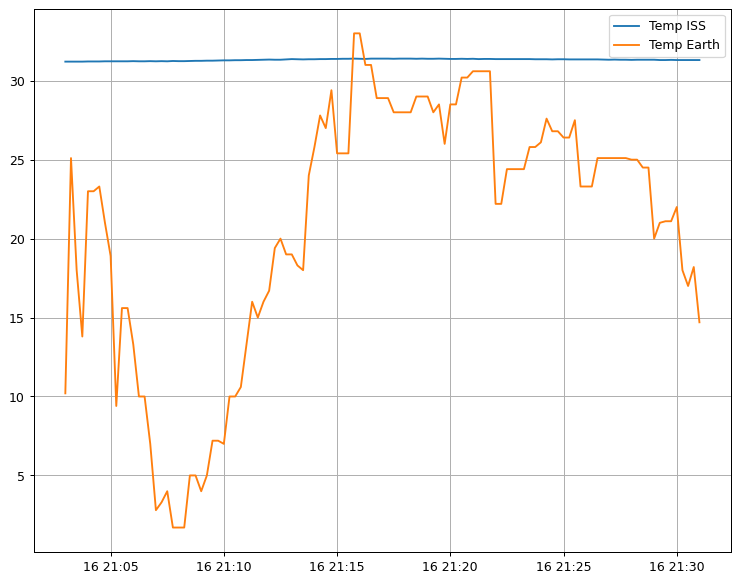

In [25]:
import os
import pandas
import math

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
file_earth = os.path.join(path_atlantes, RESULTS_FILE4)    # Ruta fichero CSV datos Tierra

data_iss = pandas.read_csv(file_iss, nrows=419, parse_dates=[0]).tail(113)        # Leemos sólo las filas que nos interesan
data_earth = pandas.read_csv(file_earth, nrows=419, parse_dates=[0]).tail(113)    # Leemos sólo las filas que nos interesan

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
# Columnas en fichero datos Tierra: datetime, picture_file, temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco
data_x = data_iss.datetime                    # Datos de la columna 'datetime'
data_y1 = data_iss.temp_p                     # Datos de la columna 'temp_p'
data_y2 = data_earth.temp                     # Datos de la columna 'temp'
data_y2 = list(data_y2)

# Rellenamos los datos que faltan
last_y2 = data_y2[0]
for i in range(0, len(data_y2)):
    if not math.isnan(data_y2[i]):
        last_y2 = data_y2[i]
    data_y2[i] = last_y2

fig, ax = plt.subplots()                      # Preparamos los objetos para dibujar con matplotlib
ax.plot(data_x, data_y1, label="Temp ISS")    # Representamos los datos de 'temp_p' frente a 'datetime'
ax.plot(data_x, data_y2, label="Temp Earth")  # Representamos los datos de 'temp' frente a 'datetime'

plt.legend()                                  # Incluimos una leyenda en la gráfica
plt.grid()                                    # Incluimos una rejilla en la gráfica
plt.show()                                    # Mostramos la gráfica

Como era de esperar, la gráfica anterior muestra la ventaja de la estación al volar por encima de la atmósfera, lo que le permite evitar las condiciones tan rápidamente cambiantes a la velocidad a la que se desplaza sobre la superficie terrestre. Seguramente los valores de la temperatura real en la ISS son menores a los obtenidos con el sensor de temperatura de la Raspberry Pi que estará afectada por su propio calor interno. Aunque la variación sí que resulta creíble. De hecho como vimos en el apartado **Gráficas tipo 2: Datos con distintas unidades**, parece encontrarse una correlación de la ligera variación que registra el sensor con el grado de insolación que recibe la estación.

Vamos a sonificar las dos series de datos anteriores.

In [26]:
import os
import pandas
import sonify
import IPython

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
file_earth = os.path.join(path_atlantes, RESULTS_FILE4)    # Ruta fichero CSV datos Tierra

data_iss = pandas.read_csv(file_iss, nrows=419, parse_dates=[0]).tail(113)        # Leemos sólo las filas que nos interesan
data_earth = pandas.read_csv(file_earth, nrows=419, parse_dates=[0]).tail(113)    # Leemos sólo las filas que nos interesan

snd_f = "temperatures_iss_earth"

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
# Columnas en fichero datos Tierra: datetime, picture_file, temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco
data_x = data_iss.datetime                    # Datos de la columna 'datetime'
data_y1 = data_iss.temp_p                     # Datos de la columna 'temp_p'
data_y1_normalized = sonify.scale_list_to_range2(data_y1, new_min=20, new_max=100, old_min=0, old_max=35)
data_y2 = data_earth.temp                     # Datos de la columna 'temp'
data_y2_normalized = sonify.scale_list_to_range2(data_y2, new_min=20, new_max=100, old_min=0, old_max=35)

data_x = []
x = 0
last_y1 = data_y1_normalized[0]
last_y2 = data_y2_normalized[0]
for i in range(0, len(data_y1_normalized)):
    data_x.append(x)
    if not math.isnan(data_y1_normalized[i]):
        last_y1 = data_y1_normalized[i]
    data_y1_normalized[i] = last_y1
    if not math.isnan(data_y2_normalized[i]):
        last_y2 = data_y2_normalized[i]
    data_y2_normalized[i] = last_y2
    x += 0.2

multitrack_data = []
multitrack_data.append(list(zip(data_x, data_y1_normalized)))
multitrack_data.append(list(zip(data_x, data_y2_normalized)))

# Let's add some instruments to each track!
instruments_to_add = ['acoustic grand piano', 'church organ']

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)

sonify.create_midi_from_data(multitrack_data_with_instruments, track_type='multiple', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f + ".wav")

Output hidden; open in https://colab.research.google.com to view.

En la sonificación anterior, la temperatura de la ISS es "interpretada" por el piano martilleante y la de la superficie en tierra con un órgano. Se observa claramente como la nota del piano es prácticamente constante mientras que el órgano varía el tono continuamente.

Esto realmente era nuestro objetivo último, por lo que podríamos considerar terminado nuestro trabajo. Ahora nos gustaría componer un vídeo con las fotos tomadas de la superficie de la Tierra y el sonido que acabamos de crear.

Antes de empezar tenemos que preparar las fotos copiando las que hemos seleccionado (desde la `atlantes_307.jpg` hasta la `atlantes_419.jpg`) y renombrándolas para que tengan un número correlativo desde `001` hasta `113`. Ya hemos realizado esa selección sobre el directorio `atlantes_fly_over_america`. Para realizar el vídeo sólo resta ejecutar la siguiente celda. En ella primero se crea un vídeo con la serie de fotos y luego se le añade como banda sonora la sonificación anterior (le cuesta un poco; el reproductor del vídeo en Firefox da un error de MIME types; usar Chrome):

In [27]:
from IPython.display import HTML
from base64 import b64encode

!ffmpeg -y -loglevel quiet -f image2 -r 5 -i atlantes_fly_over_america/%03d.jpg -vf scale=320:240 -r:v 5 -c:v libx264 -qp 0 -preset veryslow -an fly_over_america_video.mp4
!ffmpeg -y -loglevel quiet -i fly_over_america_video.mp4 -i temperatures_iss_earth.wav -c:v copy -c:a aac temperatures_iss_earth.mp4

mp4 = open('temperatures_iss_earth.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

El mismo vídeo en alta resolución en YouTube:

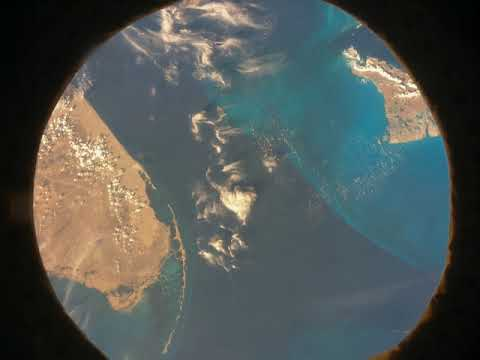

In [28]:
import IPython

IPython.display.YouTubeVideo('Hl1exe3S_cI')

Observando el resultado final, parece detectarse cómo la temperatura al sobrevolar el mar es en general más alta (se detecta por las notas más agudas del órgano). También se detecta que en general la temperatura en sudamérica es más alta que en norteamérica.

En teoría ya habríamos conseguido el objetivo de nuestro proyecto. A partir de ahora, vamos a aprovechar que ya dominamos las técnicas para sonificar series de datos y para crear vídeos stopmotion con las fotos, para tratar de conseguir sonificaciones más efectistas.

Vamos a intentar más sonificaciones con los datos que tenemos para ver si tenemos suerte y alguna de ellas resulta medianamente armónica.

El resultado de sonificar varias de las columnas de datos del sobrevuelo por el continente americano (concretamente temp, dwpt, rhum, wspd y pres) resultó demasiado cacofónico como se puede comprobar a continuación:

In [29]:
import IPython

IPython.display.Audio("temp_dwpt_rhum_wspd_pres.wav")

Output hidden; open in https://colab.research.google.com to view.

Por lo que decidimos continuar con la estrategia de sonificar los datos por separado como hicimos con la temperatura.

Los únicos datos comparables entre ISS y Tierra además de la temperatura que ya hemos utilizado, son:

* humidity
* pressure

Vamos pues a repetir el proceso hecho la temperatura pero esta vez con humedad y presión.

## Sonificación 2: humedad relativa en ISS y Tierra

Empezamos haciendo una representación gráfica de lo que vamos a sonificar:

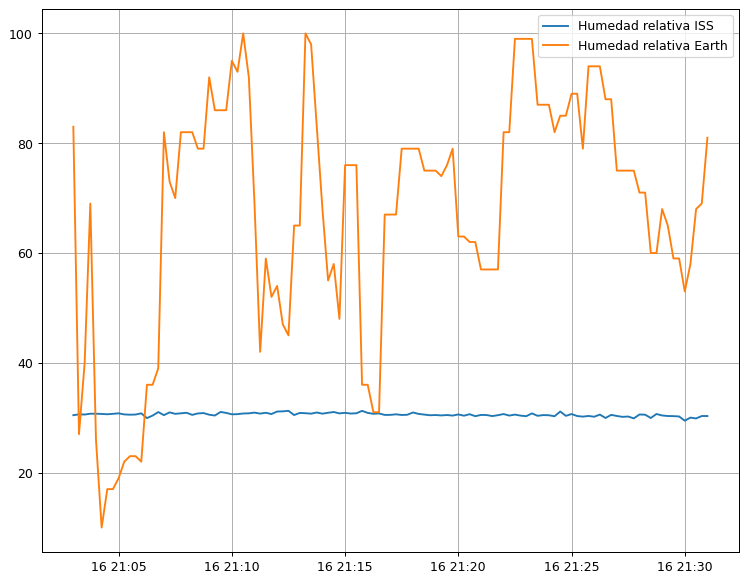

In [30]:
import os
import pandas
import math

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
file_earth = os.path.join(path_atlantes, RESULTS_FILE4)    # Ruta fichero CSV datos Tierra

data_iss = pandas.read_csv(file_iss, nrows=419, parse_dates=[0]).tail(113)        # Leemos sólo las filas que nos interesan
data_earth = pandas.read_csv(file_earth, nrows=419, parse_dates=[0]).tail(113)    # Leemos sólo las filas que nos interesan

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
# Columnas en fichero datos Tierra: datetime, picture_file, temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco
data_x = data_iss.datetime                    # Datos de la columna 'datetime'
data_y1 = data_iss.humidity                   # Datos de la columna 'humidity'
data_y2 = data_earth.rhum                     # Datos de la columna 'rhum'
data_y2 = list(data_y2)

# Rellenamos los datos que faltan
last_y2 = data_y2[0]
for i in range(0, len(data_y2)):
    if not math.isnan(data_y2[i]):
        last_y2 = data_y2[i]
    data_y2[i] = last_y2

fig, ax = plt.subplots()                      # Preparamos los objetos para dibujar con matplotlib
ax.plot(data_x, data_y1, label="Humedad relativa ISS")    # Representamos los datos de 'humidity' frente a 'datetime'
ax.plot(data_x, data_y2, label="Humedad relativa Earth")  # Representamos los datos de 'rhum' frente a 'datetime'

plt.legend()                                  # Incluimos una leyenda en la gráfica
plt.grid()                                    # Incluimos una rejilla en la gráfica
plt.show()                                    # Mostramos la gráfica

Finalmente sonificamos:

In [31]:
import os
import pandas
import sonify
import IPython

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
file_earth = os.path.join(path_atlantes, RESULTS_FILE4)    # Ruta fichero CSV datos Tierra

data_iss = pandas.read_csv(file_iss, nrows=419, parse_dates=[0]).tail(113)        # Leemos sólo las filas que nos interesan
data_earth = pandas.read_csv(file_earth, nrows=419, parse_dates=[0]).tail(113)    # Leemos sólo las filas que nos interesan

snd_f = "humidity_iss_earth"

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
# Columnas en fichero datos Tierra: datetime, picture_file, temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco
data_x = data_iss.datetime                    # Datos de la columna 'datetime'
data_y1 = data_iss.humidity                     # Datos de la columna 'humidity'
data_y1_normalized = sonify.scale_list_to_range2(data_y1, new_min=20, new_max=100, old_min=0, old_max=100)
data_y2 = data_earth.rhum                     # Datos de la columna 'rhum'
data_y2_normalized = sonify.scale_list_to_range2(data_y2, new_min=20, new_max=100, old_min=0, old_max=100)

data_x = []
x = 0
last_y1 = data_y1_normalized[0]
last_y2 = data_y2_normalized[0]
for i in range(0, len(data_y1_normalized)):
    data_x.append(x)
    if not math.isnan(data_y1_normalized[i]):
        last_y1 = data_y1_normalized[i]
    data_y1_normalized[i] = last_y1
    if not math.isnan(data_y2_normalized[i]):
        last_y2 = data_y2_normalized[i]
    data_y2_normalized[i] = last_y2
    x += 0.2

multitrack_data = []
multitrack_data.append(list(zip(data_x, data_y1_normalized)))
multitrack_data.append(list(zip(data_x, data_y2_normalized)))

# Let's add some instruments to each track!
instruments_to_add = ['acoustic grand piano', 'church organ']

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)

sonify.create_midi_from_data(multitrack_data_with_instruments, track_type='multiple', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f + ".wav")

Output hidden; open in https://colab.research.google.com to view.

El resultado sigue sin ser muy espectacular y similar a lo obtenido con las temperaturas.

## Sonificación 3: presión en ISS y Tierra

Empezamos haciendo una representación gráfica de lo que vamos a sonificar:

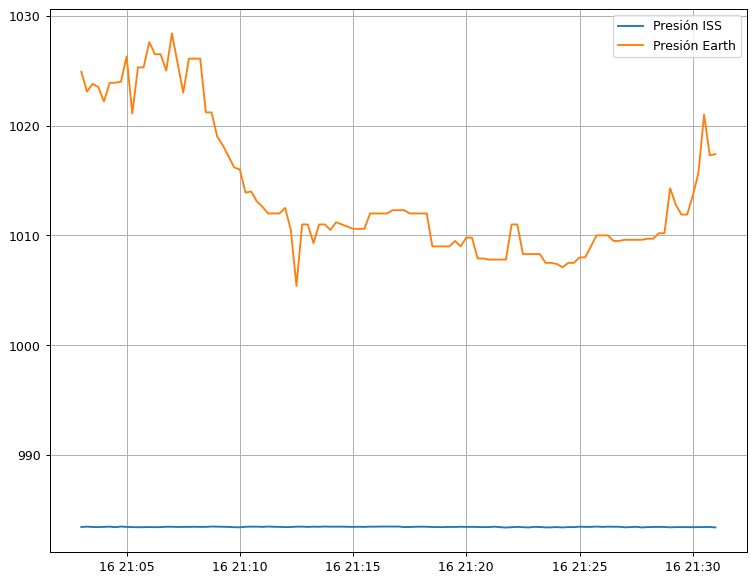

In [32]:
import os
import pandas
import math

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
file_earth = os.path.join(path_atlantes, RESULTS_FILE4)    # Ruta fichero CSV datos Tierra

data_iss = pandas.read_csv(file_iss, nrows=419, parse_dates=[0]).tail(113)        # Leemos sólo las filas que nos interesan
data_earth = pandas.read_csv(file_earth, nrows=419, parse_dates=[0]).tail(113)    # Leemos sólo las filas que nos interesan

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
# Columnas en fichero datos Tierra: datetime, picture_file, temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco
data_x = data_iss.datetime                    # Datos de la columna 'datetime'
data_y1 = data_iss.pressure                   # Datos de la columna 'pressure'
data_y2 = data_earth.pres                     # Datos de la columna 'pres'
data_y2 = list(data_y2)

# Rellenamos los datos que faltan
last_y2 = data_y2[0]
for i in range(0, len(data_y2)):
    if not math.isnan(data_y2[i]):
        last_y2 = data_y2[i]
    data_y2[i] = last_y2

fig, ax = plt.subplots()                      # Preparamos los objetos para dibujar con matplotlib
ax.plot(data_x, data_y1, label="Presión ISS")    # Representamos los datos de 'pressure' frente a 'datetime'
ax.plot(data_x, data_y2, label="Presión Earth")  # Representamos los datos de 'pres' frente a 'datetime'

plt.legend()                                  # Incluimos una leyenda en la gráfica
plt.grid()                                    # Incluimos una rejilla en la gráfica
plt.show()                                    # Mostramos la gráfica

Sonificando...

In [33]:
import os
import pandas
import sonify
import IPython

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
file_earth = os.path.join(path_atlantes, RESULTS_FILE4)    # Ruta fichero CSV datos Tierra

data_iss = pandas.read_csv(file_iss, nrows=419, parse_dates=[0]).tail(113)        # Leemos sólo las filas que nos interesan
data_earth = pandas.read_csv(file_earth, nrows=419, parse_dates=[0]).tail(113)    # Leemos sólo las filas que nos interesan

snd_f = "pressure_iss_earth"

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
# Columnas en fichero datos Tierra: datetime, picture_file, temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco
data_x = data_iss.datetime                    # Datos de la columna 'datetime'
data_y1 = data_iss.pressure                     # Datos de la columna 'pressure'
data_y1_normalized = sonify.scale_list_to_range2(data_y1, new_min=20, new_max=100, old_min=980, old_max=1030)
data_y2 = data_earth.pres                     # Datos de la columna 'pres'
data_y2_normalized = sonify.scale_list_to_range2(data_y2, new_min=20, new_max=100, old_min=980, old_max=1030)

data_x = []
x = 0
last_y1 = data_y1_normalized[0]
last_y2 = data_y2_normalized[0]
for i in range(0, len(data_y1_normalized)):
    data_x.append(x)
    if not math.isnan(data_y1_normalized[i]):
        last_y1 = data_y1_normalized[i]
    data_y1_normalized[i] = last_y1
    if not math.isnan(data_y2_normalized[i]):
        last_y2 = data_y2_normalized[i]
    data_y2_normalized[i] = last_y2
    x += 0.2

multitrack_data = []
multitrack_data.append(list(zip(data_x, data_y1_normalized)))
multitrack_data.append(list(zip(data_x, data_y2_normalized)))

# Let's add some instruments to each track!
instruments_to_add = ['acoustic grand piano', 'church organ']

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)

sonify.create_midi_from_data(multitrack_data_with_instruments, track_type='multiple', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f + ".wav")

Output hidden; open in https://colab.research.google.com to view.

De nuevo, nada rompedor.

## Sonificación 4: componentes magnetómetro en ISS

Vamos a cambiar de estrategia. Representando gráficamente todos los datos capturados en la estación por el programa ejecutado en AstroPi, se encuentra que las únicas magnitudes que producen un espectro de valores continuo y cuya variación puede tener algún interés son:

* yaw
* mag_x
* mag_y
* mag_z

Como las únicas que tiene sentido manejar en conjunto son las tres últimas, vamos a centrarnos en ellas. Empezamos representando gráficamente su variación. Esta vez vamos a utilizar el conjunto de datos, no sólo el sobrevuelo sobre América.

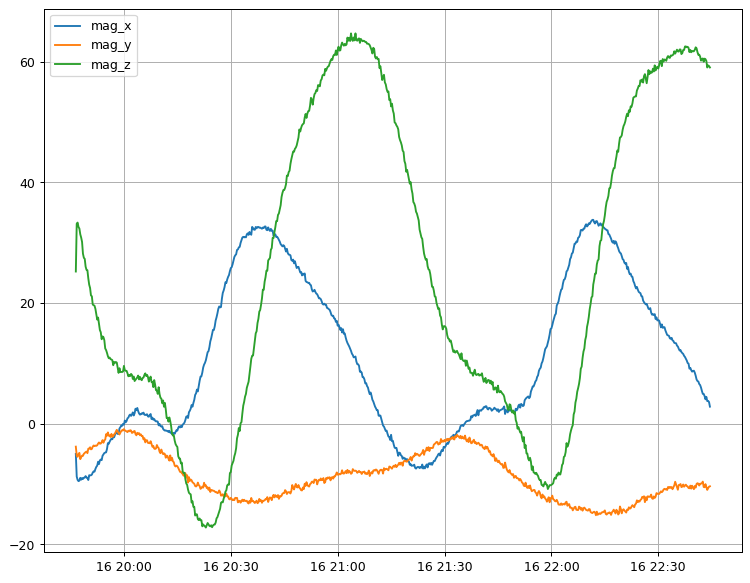

In [34]:
import os
import pandas
import math

file_iss = os.path.join(path_atlantes, RESULTS_FILE)       # Ruta fichero CSV datos ISS
data_iss = pandas.read_csv(file_iss, parse_dates=[0])       # Leemos todo el fichero

# Columnas en fichero datos ISS: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
data_x = data_iss.datetime
data_y1 = data_iss.mag_x
data_y2 = data_iss.mag_y
data_y3 = data_iss.mag_z

fig, ax = plt.subplots()
ax.plot(data_x, data_y1, label="mag_x")
ax.plot(data_x, data_y2, label="mag_y")
ax.plot(data_x, data_y3, label="mag_z")

plt.legend()
plt.grid()
plt.show()

La sonificación es la siguiente. Esta vez hemos acelerado el ritmo (una nota cada décima de segundo) ya que vamos a utilizar todos los datos:

In [35]:
import os
import pandas
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV
snd_f = "mag_xyz"

data = pandas.read_csv(file, parse_dates=[0])       # Leemos todo el fichero

# Columnas en fichero: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
data_x = data.datetime                              # Datos de la columna 'datetime'
data_y1 = data.mag_x                                # Datos de la columna 'mag_x'
data_y1_normalized = sonify.scale_list_to_range2(data_y1, new_min=20, new_max=100, old_min=-20, old_max=70)
data_y2 = data.mag_y                                # Datos de la columna 'mag_y'
data_y2_normalized = sonify.scale_list_to_range2(data_y2, new_min=20, new_max=100, old_min=-20, old_max=70)
data_y3 = data.mag_z                                # Datos de la columna 'mag_z'
data_y3_normalized = sonify.scale_list_to_range2(data_y3, new_min=20, new_max=100, old_min=-20, old_max=70)

data_x = []
x = 0
for i in range(0, len(data_y1_normalized)):
    data_x.append(x)
    x += 0.1


multitrack_data = []
multitrack_data.append(list(zip(data_x, data_y1_normalized)))
multitrack_data.append(list(zip(data_x, data_y2_normalized)))
multitrack_data.append(list(zip(data_x, data_y3_normalized)))


# Let's add some instruments to each track!
instruments_to_add = ['church organ', 'accordion', 'cello']

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)


sonify.create_midi_from_data(multitrack_data_with_instruments, track_type='multiple', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

Output hidden; open in https://colab.research.google.com to view.

Creamos el vídeo stopmotion con esta sonificación (la ejecución de la siguiente celda tarda un poco):

In [36]:
from IPython.display import HTML
from base64 import b64encode

!ffmpeg -y -loglevel quiet -f image2 -r 10 -i atlantes/atlantes_%03d.jpg -vf scale=320:240 -r:v 10 -c:v libx264 -qp 0 -preset veryslow -an complete_fly_video.mp4
!ffmpeg -y -loglevel quiet -i complete_fly_video.mp4 -i mag_xyz.wav -c:v copy -c:a aac mag_xyz.mp4

mp4 = open('mag_xyz.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

El mismo vídeo en alta resolución en YouTube:

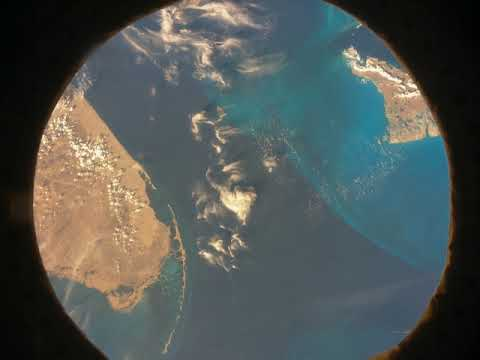

In [37]:
import IPython

IPython.display.YouTubeVideo('VSILkRGMKdA')

## Sonificación 5: módulo magnetómetro en ISS

Vamos a calcular el módulo del vector compuesto por las magnitudes `mag_x`, `mag_y` y `mag_z`, para ver cómo varía la intensidad del campo magnético de la Tierra durante la órbita de la ISS. El módulo se calcula con la siguiente función:

$Mag = \sqrt{mag_x^2 + mag_y^2 + mag_z^2}$

Empezamos representando dicho módulo gráficamente:

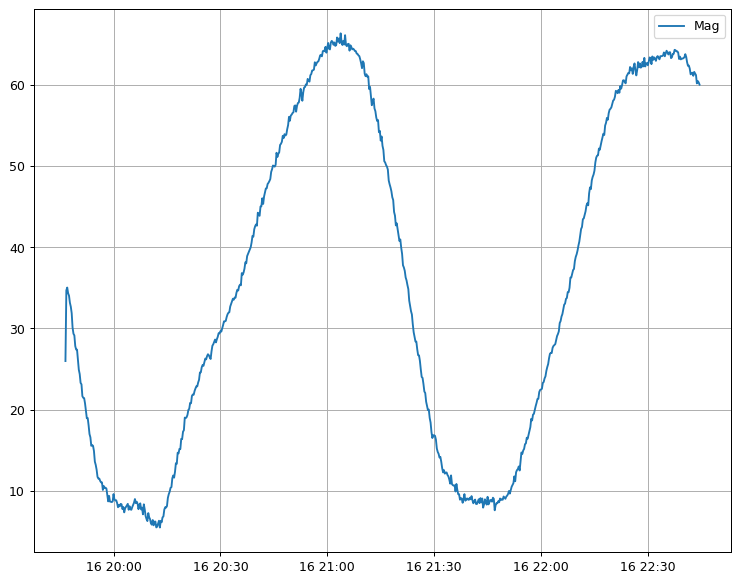

In [38]:
import os
import pandas
import numpy
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV
snd_f = "mag_xyz"

data = pandas.read_csv(file, parse_dates=[0])       # Leemos todo el fichero

# Columnas en fichero: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
data_x = data.datetime                              # Datos de la columna 'datetime'
data_y1 = data.mag_x                                # Datos de la columna 'mag_x'
data_y2 = data.mag_y                                # Datos de la columna 'mag_y'
data_y3 = data.mag_z                                # Datos de la columna 'mag_z'

data_y = numpy.sqrt(data_y1.pow(2) + data_y2.pow(2) + data_y3.pow(2))

fig, ax = plt.subplots()
ax.plot(data_x, data_y, label="Mag")

plt.legend()
plt.grid()
plt.show()

La sonificación de lo anterior será:

In [39]:
import os
import pandas
import numpy
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV
snd_f = "mag"

data = pandas.read_csv(file, parse_dates=[0])       # Leemos sólo los datos que nos interesan

# Columnas en fichero: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
data_x = data.datetime                              # Datos de la columna 'datetime'
data_y1 = data.mag_x                                # Datos de la columna 'mag_x'
data_y2 = data.mag_y                                # Datos de la columna 'mag_y'
data_y3 = data.mag_z                                # Datos de la columna 'mag_z'

data_y = numpy.sqrt(data_y1.pow(2) + data_y2.pow(2) + data_y3.pow(2))

# Normalizamos los datos entre 20 y 100
lista_normalizada = sonify.scale_list_to_range(data_y, new_min=20, new_max=100)

data_x = []
x = 0
for i in range(0, len(lista_normalizada)):
    data_x.append(x)
    x += 0.1

list_of_lists = []
list_of_lists.append(['church organ'] + list(zip(data_x, lista_normalizada)))

sonify.create_midi_from_data(list_of_lists, track_type='multiple', key='c_major', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

Output hidden; open in https://colab.research.google.com to view.

Como siempre, insertamos la sonificación al vídeo correspondiente (en este caso a la secuencia completa de fotos):

In [40]:
from IPython.display import HTML
from base64 import b64encode

!ffmpeg -y -loglevel quiet -i complete_fly_video.mp4 -i mag.wav -c:v copy -c:a aac mag.mp4

mp4 = open('mag.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

El mismo vídeo en alta resolución en YouTube:

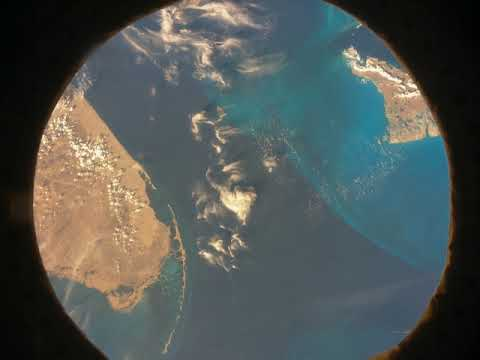

In [41]:
import IPython

IPython.display.YouTubeVideo('nXT9t3kGm1o')

## Sonificación 6: imágenes

En el apartado **Sonificando las medias de las fotografías** sonificamos las medias de los valores de los píxeles de las imágenes. Vamos a trabajar un poco más sobre esto ya que es la información cuya sonificación sincronizará mejor con la animación de dichas imágenes.

Para no hacer el vídeo muy largo y para que tenga un principio y final gradual, vamos a trabajar únicamente con los datos que van desde la imagen `atlantes_186.jpg` hasta `atlantes_431.jpg`.

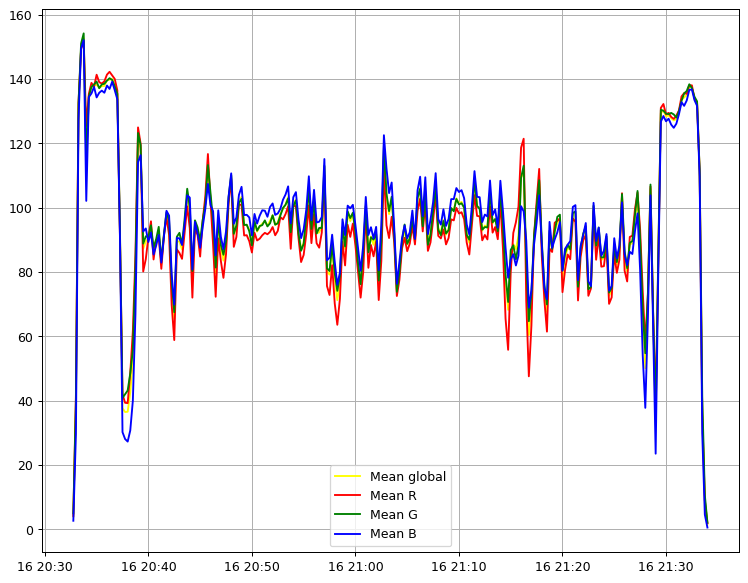

In [42]:
import os
import pandas

file = os.path.join(path_atlantes, RESULTS_FILE3)    # Ruta completa fichero CSV

# Leemos sólo los datos que nos interesan
data = pandas.read_csv(file, nrows=431, parse_dates=[0]).tail(246)

# Columnas en fichero: "datetime", "picture_file", "mean_global", "mean_r", "mean_g", "mean_b"
data_x = data.datetime                        # Datos de la columna 'datetime'
data_y1 = data.mean_global                    # Datos de la columna 'mean_global'
data_y2 = data.mean_r                         # Datos de la columna 'mean_r'
data_y3 = data.mean_g                         # Datos de la columna 'mean_g'
data_y4 = data.mean_b                         # Datos de la columna 'mean_b'

fig, ax = plt.subplots()                                      # Preparamos los objetos para dibujar con matplotlib
ax.plot(data_x, data_y1, label="Mean global", color="yellow") # Representamos los datos de 'mean_global' frente a 'datetime'
ax.plot(data_x, data_y2, label="Mean R", color="red")         # Representamos los datos de 'mean_r' frente a 'datetime'
ax.plot(data_x, data_y3, label="Mean G", color="green")       # Representamos los datos de 'mean_g' frente a 'datetime'
ax.plot(data_x, data_y4, label="Mean B", color="blue")        # Representamos los datos de 'mean_b' frente a 'datetime'

plt.legend()                                  # Incluimos una leyenda en la gráfica
plt.grid()                                    # Incluimos una rejilla en la gráfica
plt.show()                                    # Mostramos la gráfica

Empezamos sonificando las medias de los cuatro canales de datos que tenemos asociados a las imágenes para el rango de fotos que acabamos de comentar:

In [43]:
import os
import pandas
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE3)    # Ruta completa fichero CSV
snd_f = "1orbit_pictures_means"

data = pandas.read_csv(file, nrows=431, parse_dates=[0]).tail(246)        # Leemos sólo las filas que nos interesan

# Columnas en fichero: "datetime", "picture_file", "mean_global", "mean_r", "mean_g", "mean_b"
data_y1 = data.mean_global                    # Datos de la columna 'mean_global'
data_y1_normalized = sonify.scale_list_to_range(data_y1, new_min=20, new_max=100)
data_y2 = data.mean_r                         # Datos de la columna 'mean_r'
data_y2_normalized = sonify.scale_list_to_range(data_y2, new_min=20, new_max=100)
data_y3 = data.mean_g                         # Datos de la columna 'mean_g'
data_y3_normalized = sonify.scale_list_to_range(data_y3, new_min=20, new_max=100)
data_y4 = data.mean_b                         # Datos de la columna 'mean_b'
data_y4_normalized = sonify.scale_list_to_range(data_y4, new_min=20, new_max=100)

data_x = []
x = 0
for i in range(0, len(data_y1_normalized)):
    data_x.append(x)
    x += 0.1

multitrack_data = []
multitrack_data.append(list(zip(data_x, data_y1_normalized)))
multitrack_data.append(list(zip(data_x, data_y2_normalized)))
multitrack_data.append(list(zip(data_x, data_y3_normalized)))
multitrack_data.append(list(zip(data_x, data_y4_normalized)))

# Let's add some instruments to each track!
instruments_to_add = ['steel drums', 'rock organ', 'pizzicato strings', 'oboe']

multitrack_data_with_instruments = []
for index, track in enumerate(multitrack_data):
    multitrack_data_with_instruments.append([instruments_to_add[index]] + track)

sonify.create_midi_from_data(multitrack_data_with_instruments, track_type='multiple', key='c_major', file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

Output hidden; open in https://colab.research.google.com to view.

Ahora construimos el vídeo con esas imágenes y le acoplamos la sonificación anterior. Al igual que hicimos en la **Sonificación 1**, antes de empezar tenemos que preparar las fotos copiando las que hemos seleccionado (desde la `atlantes_186.jpg` hasta la `atlantes_431.jpg`) y renombrándolas para que tengan un número correlativo desde 001 hasta 246. Hemos realizado esa selección sobre el directorio `atlantes_1orbit`. Para realizar el vídeo sólo resta ejecutar la siguiente celda:

In [44]:
from IPython.display import HTML
from base64 import b64encode

!ffmpeg -y -loglevel quiet -f image2 -r 10 -i atlantes_1orbit/%03d.jpg -vf scale=320:240 -r:v 10 -c:v libx264 -qp 0 -preset veryslow -an 1orbit_video.mp4
!ffmpeg -y -loglevel quiet -i 1orbit_video.mp4 -i 1orbit_pictures_means.wav -c:v copy -c:a aac 1orbit_pictures_means.mp4

mp4 = open('1orbit_pictures_means.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

El mismo vídeo en alta resolución en YouTube:

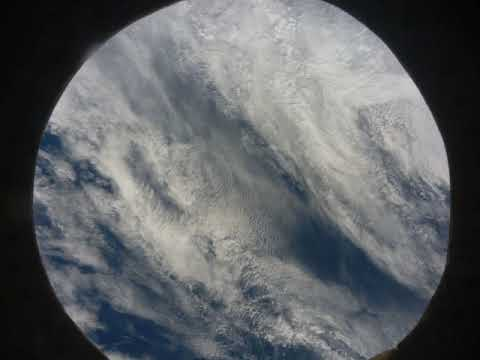

In [45]:
import IPython

IPython.display.YouTubeVideo('SL1XojuapDE')

## Sonificación 7: latitud

Otra sonificación que seguramente resulta interesante es la de la latitud de la estación. Esta magnitud tiene forma senoidal, lo que debería producir una variación de sonido continua y gradual. Aunque a la hora de ver el vídeo no se aprecia la relación entre las notas y las imágenes, la sonificación ayuda a interpretar lo que estamos viendo al permitir la identificación inmediata a de la latitud de las fotografías.

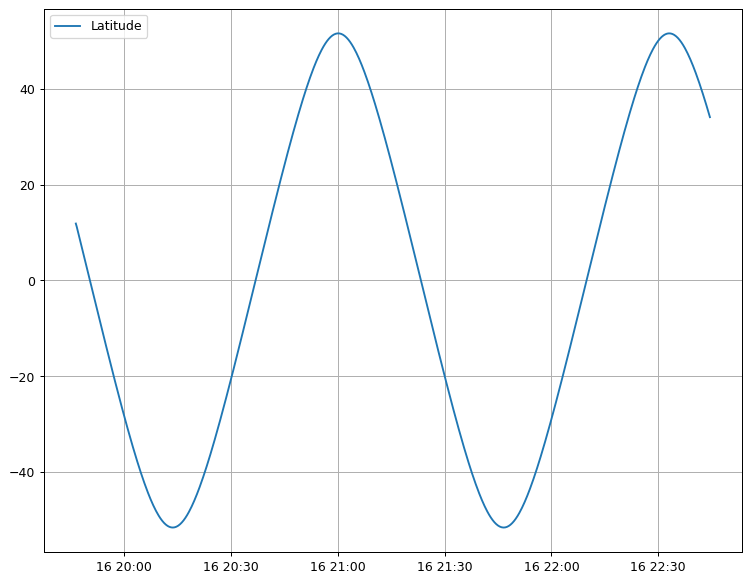

In [46]:
import os
import pandas
import numpy
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE)    # Ruta completa fichero CSV
snd_f = "latitude"

data = pandas.read_csv(file, parse_dates=[0])       # Leemos todo el fichero

# Columnas en fichero: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
data_x = data.datetime                              # Datos de la columna 'datetime'
data_y = data.latitude                              # Datos de la columna 'latitude'

fig, ax = plt.subplots()
ax.plot(data_x, data_y, label="Latitude")

plt.legend()
plt.grid()
plt.show()

In [47]:
import os
import pandas
import sonify
import IPython

file = os.path.join(path_atlantes, RESULTS_FILE)     # Ruta completa fichero CSV
snd_f = "latitude"

data = pandas.read_csv(file, parse_dates=[0])        # Leemos todo el fichero

# Columnas en fichero: datetime,picture_file,latitude,longitude,temp_cpu,temp_h,temp_p,humidity,pressure,pitch,roll,yaw,mag_x,mag_y,mag_z,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
data_y1 = data.latitude                              # Datos de la columna 'latitude'
data_y1_normalized = sonify.scale_list_to_range(data_y1, new_min=20, new_max=100)

final_data = []
x = 0
for i in range(0, len(data_y1_normalized)):
    final_data.append((x, data_y1_normalized[i]))
    x += 0.1

sonify.create_midi_from_data(final_data, file=snd_f+".mid")

# Convertimos el fichero MIDI en WAV para reproducirlo en el cuaderno
!fluidsynth /content/default.sf2 -F {snd_f}.wav -i -n -T wav {snd_f}.mid
IPython.display.Audio(snd_f+".wav")

Output hidden; open in https://colab.research.google.com to view.

Creamos el vídeo stopmotion con esta sonificación:

In [48]:
from IPython.display import HTML
from base64 import b64encode

!ffmpeg -y -loglevel quiet -i complete_fly_video.mp4 -i latitude.wav -c:v copy -c:a aac latitude.mp4

mp4 = open('latitude.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


Output hidden; open in https://colab.research.google.com to view.

El mismo vídeo en alta resolución en YouTube:

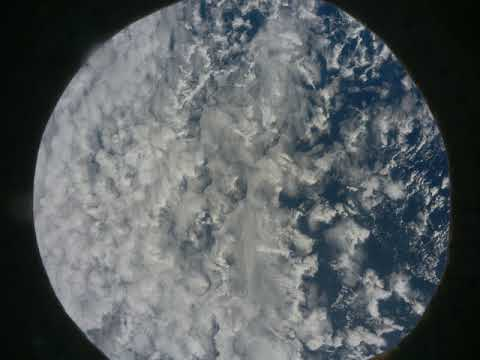

In [49]:
import IPython

IPython.display.YouTubeVideo('G8YluWG5hmw')



---


**FIN**